In [8]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
import math

# Get the current notebook's directory
notebook_dir = Path().absolute()

# Set the working directory to the notebook's directory
os.chdir(notebook_dir)

from constants import Cryptos, CCMIX, MarketIndex
from statistical_tests import GRANKTTest,GSignTest
import warnings
import math
from AR_models import MarketModel
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import math

### Series characteristics

In [5]:
def plot_multiple_pacf(target_value='log_returns', lags=40, title_prefix="PACF Plot"):
    # Determine the number of rows needed for 3 columns
    n_cols = 3
    n_rows = (len(Cryptos) + n_cols - 1) // n_cols  # Calculate rows to accommodate all series
    
    # Set up the figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    # Loop over each series and plot PACF in a subplot
    for i,crypto in enumerate(Cryptos):
        pacf_values, confint = MarketIndex.get_partial_autocorrelation(crypto.value.data[target_value], lags)
        axes[i].stem(range(len(pacf_values)), pacf_values,)
        axes[i].hlines([confint, -confint], xmin=0, xmax=lags, colors='red', linestyles='dashed')
        axes[i].set_title(f"{title_prefix} {crypto.value.name}")
        axes[i].set_xlabel("Lag")
        axes[i].set_ylabel("Partial Autocorrelation")
    
    # Hide any unused subplots if n_series is not a multiple of n_cols
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Data for CCMIX loaded successfully.
Data for Bitcoin Gold loaded successfully.
Market returns added successfully to Bitcoin Gold data.
params
[0.7207914  0.97440669]
pvalues
[0.00175773 0.        ]
Data for Einsteinium loaded successfully.
Market returns added successfully to Einsteinium data.
params
[0.00522887 0.94896261]
pvalues
[5.19527655e-10 0.00000000e+00]
Data for Electroneum loaded successfully.
Market returns added successfully to Electroneum data.
params
[1.71255214e-04 9.84590966e-01]
pvalues
[0.11051976 0.        ]
Data for Ethereum Classic loaded successfully.
Market returns added successfully to Ethereum Classic data.
params
[0.14494776 0.99162697]
pvalues
[0.09865343 0.        ]
Data for Expanse loaded successfully.
Market returns added successfully to Expanse data.
params
[0.004566  0.9851005]
pvalues
[0.36501548 0.        ]
Data for Firo loaded successfully.
Market returns added successfully to Firo data.
params
[0.08135359 0.99005541]
pvalues
[0.22119623 0.        ]


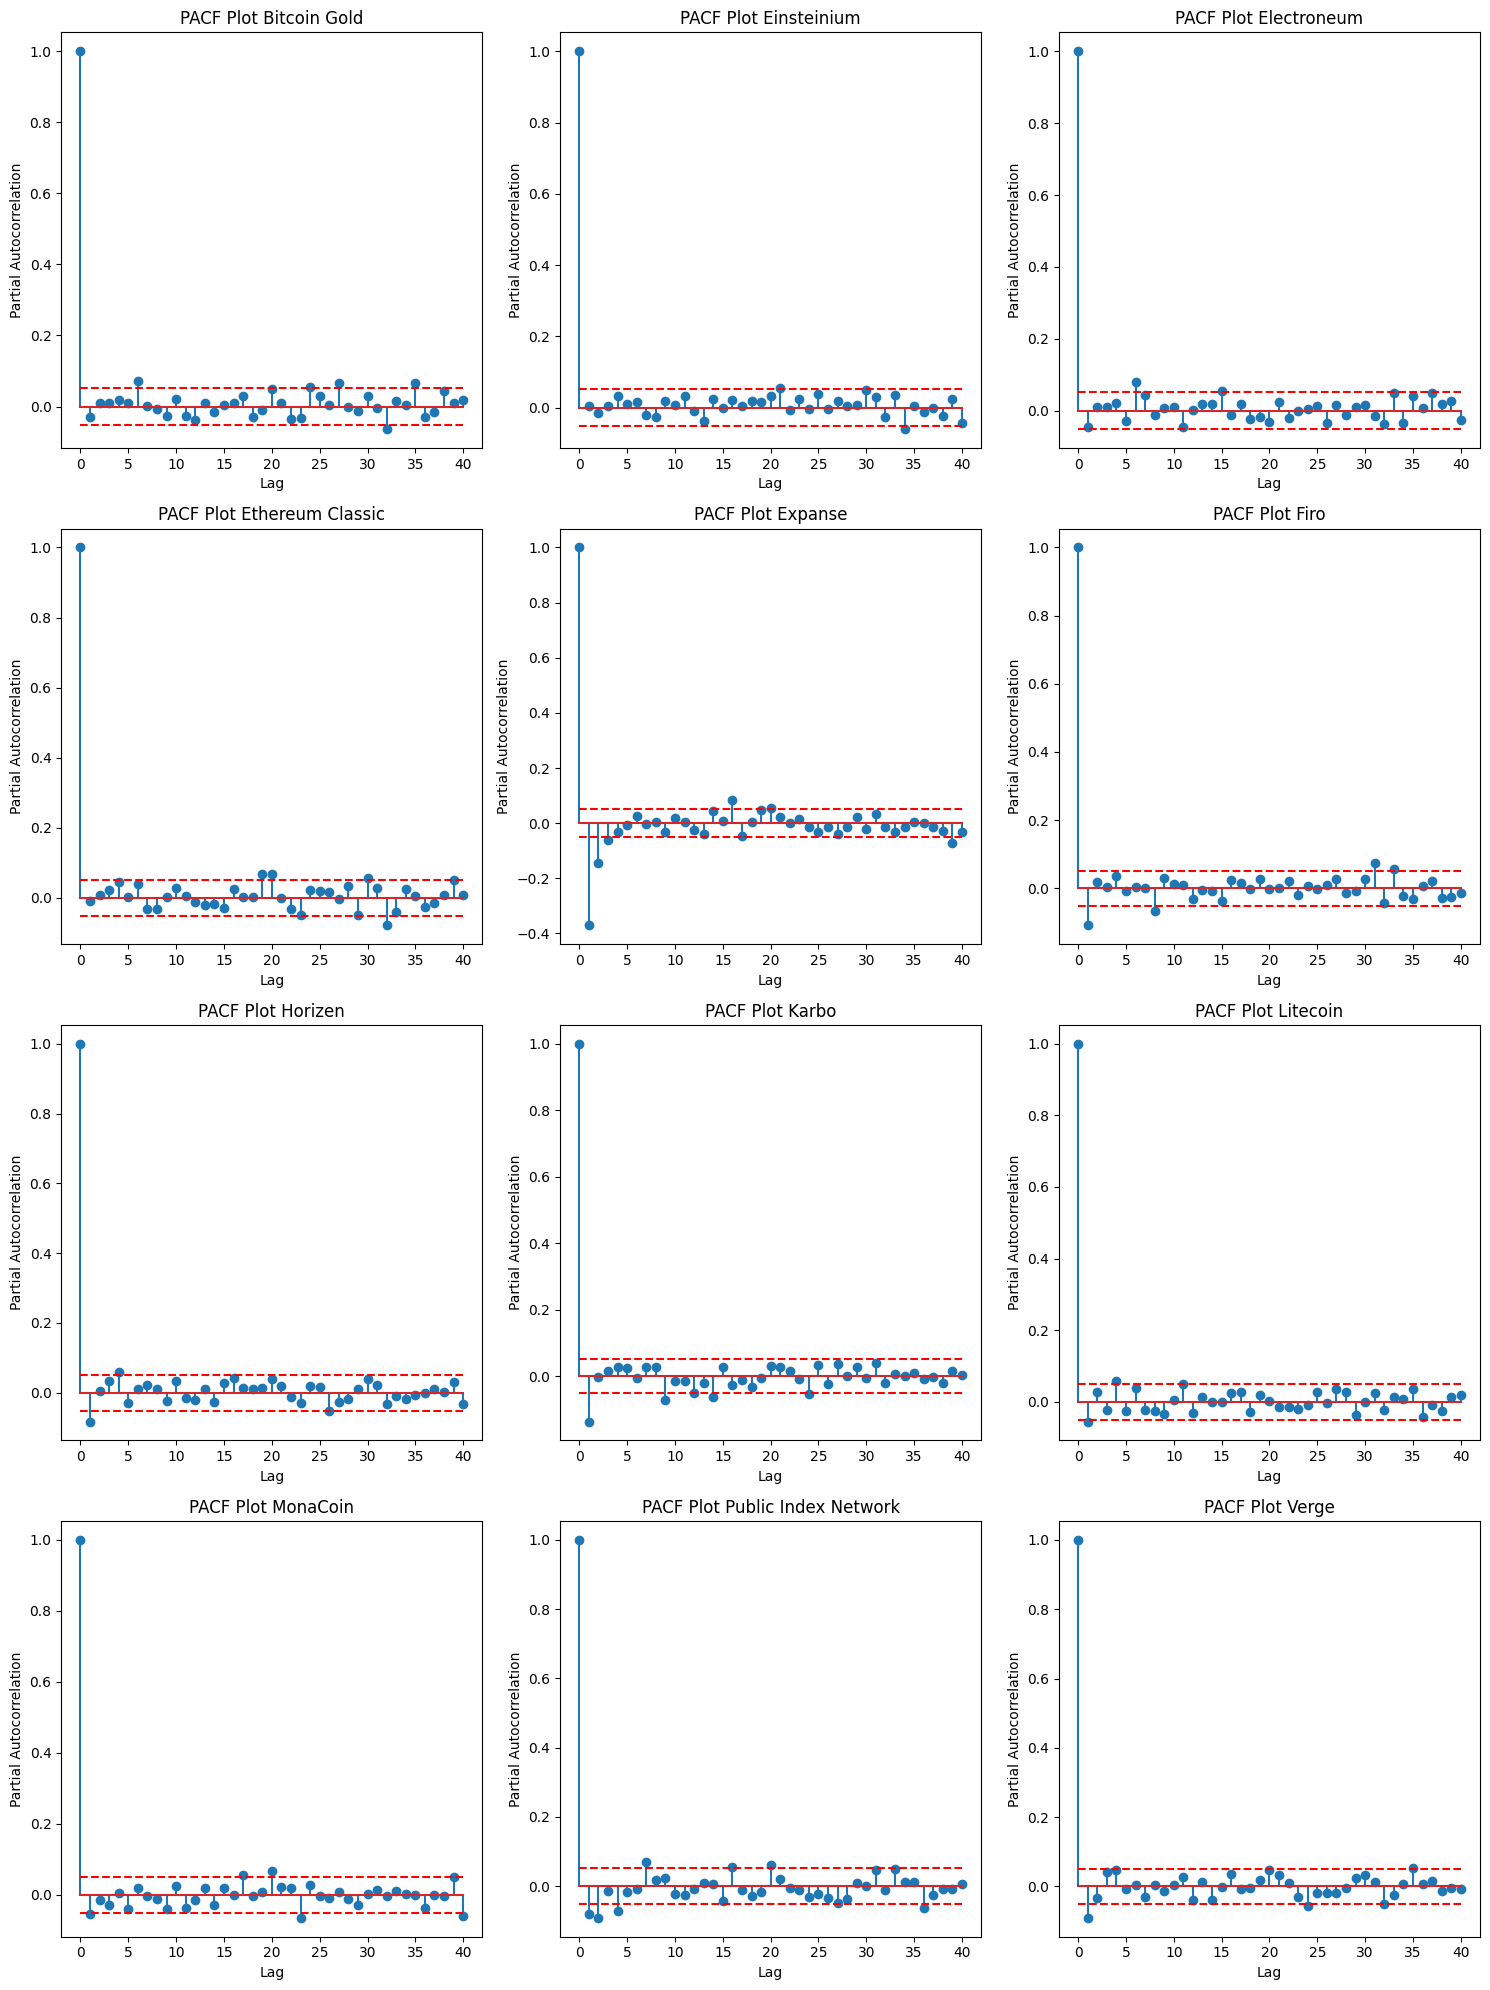

In [19]:
CCMIX.load_data()
stat_ar_params = []
ar_params = []
for crypto in Cryptos:
    crypto.value.load_data()
    crypto.value.add_market_returns(CCMIX.data)
    stat = crypto.value.test_stationarity()
    # print("Is stationary = ",stat)
    # rlt = crypto.value.run_ar_model(p=1,difference=True)
    # print("with difference : ",rlt.params)
    rlt = crypto.value.run_ar_model(p=1,difference=False)
    # print("without difference : ",rlt.params)
    ar_params.append(rlt.params[1])
    print('params')
    print(rlt.params)
    print('pvalues')
    print(rlt.pvalues)
    if stat :
        stat_ar_params.append(rlt.params[1])
    # crypto.value.plot_partial_autocorrelation(crypto.value.data['log_returns'])
plot_multiple_pacf()

In [3]:
print("mean AR coff for stationary series = ",np.mean(stat_ar_params))
print("mean AR coff for all series = ",np.mean(ar_params))

mean AR coff for stationary series =  0.9765871290851774
mean AR coff for all series =  0.9801937402545807


In [4]:
ar_params

[np.float64(0.9744066904922507),
 np.float64(0.9489626074263048),
 np.float64(0.9845909664445156),
 np.float64(0.9916269722788729),
 np.float64(0.98510049656166),
 np.float64(0.9900554091494042),
 np.float64(0.9932378943939064),
 np.float64(0.9911581024881895),
 np.float64(0.988175854615594),
 np.float64(0.9701214381231049),
 np.float64(0.9703840425238118),
 np.float64(0.9745044085573554)]

### Studying 51% attacks using the CAR method

In [5]:
def testing_abnormal_returns(abnormal_returns):
    # Generalized Rank Test
    grank_test = GRANKTTest(abnormal_returns)
    assumptions_grank = grank_test.verify_assumptions()
    assumptions_grank = pd.DataFrame(assumptions_grank)
    assumptions_grank['name'] = grank_test.name
    grank_stat = grank_test.calculate_test()
    assumptions_grank['value'] = grank_stat


    # Generalized Sign Test
    gsign_test = GSignTest(abnormal_returns)
    assumptions_gsign = gsign_test.verify_assumptions()
    assumptions_gsign = pd.DataFrame(assumptions_gsign)
    assumptions_gsign['name'] = grank_test.name
    gsign_stat = gsign_test.calculate_test()
    assumptions_gsign['value'] = gsign_stat

    return pd.concat([assumptions_grank,assumptions_gsign])

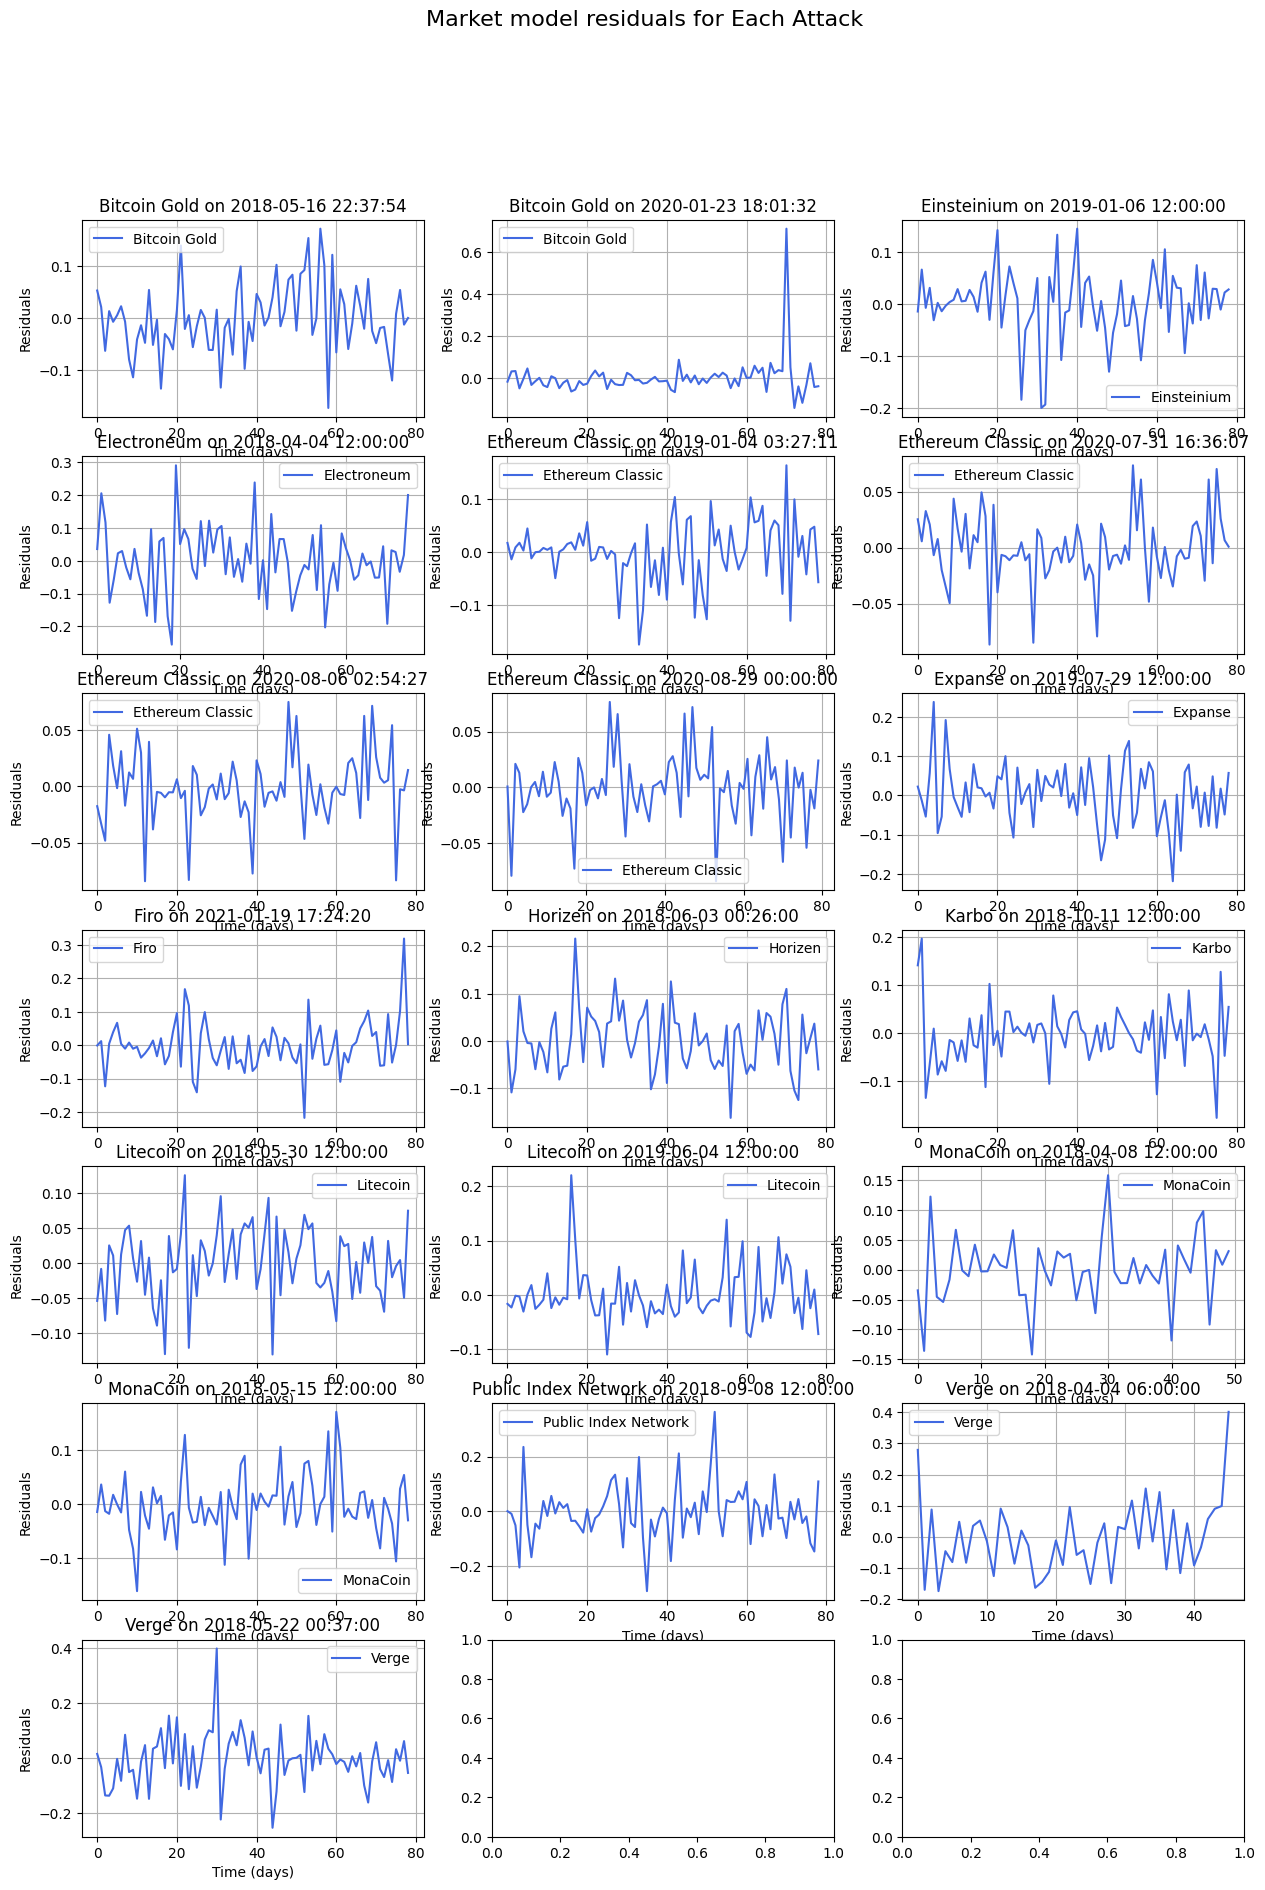

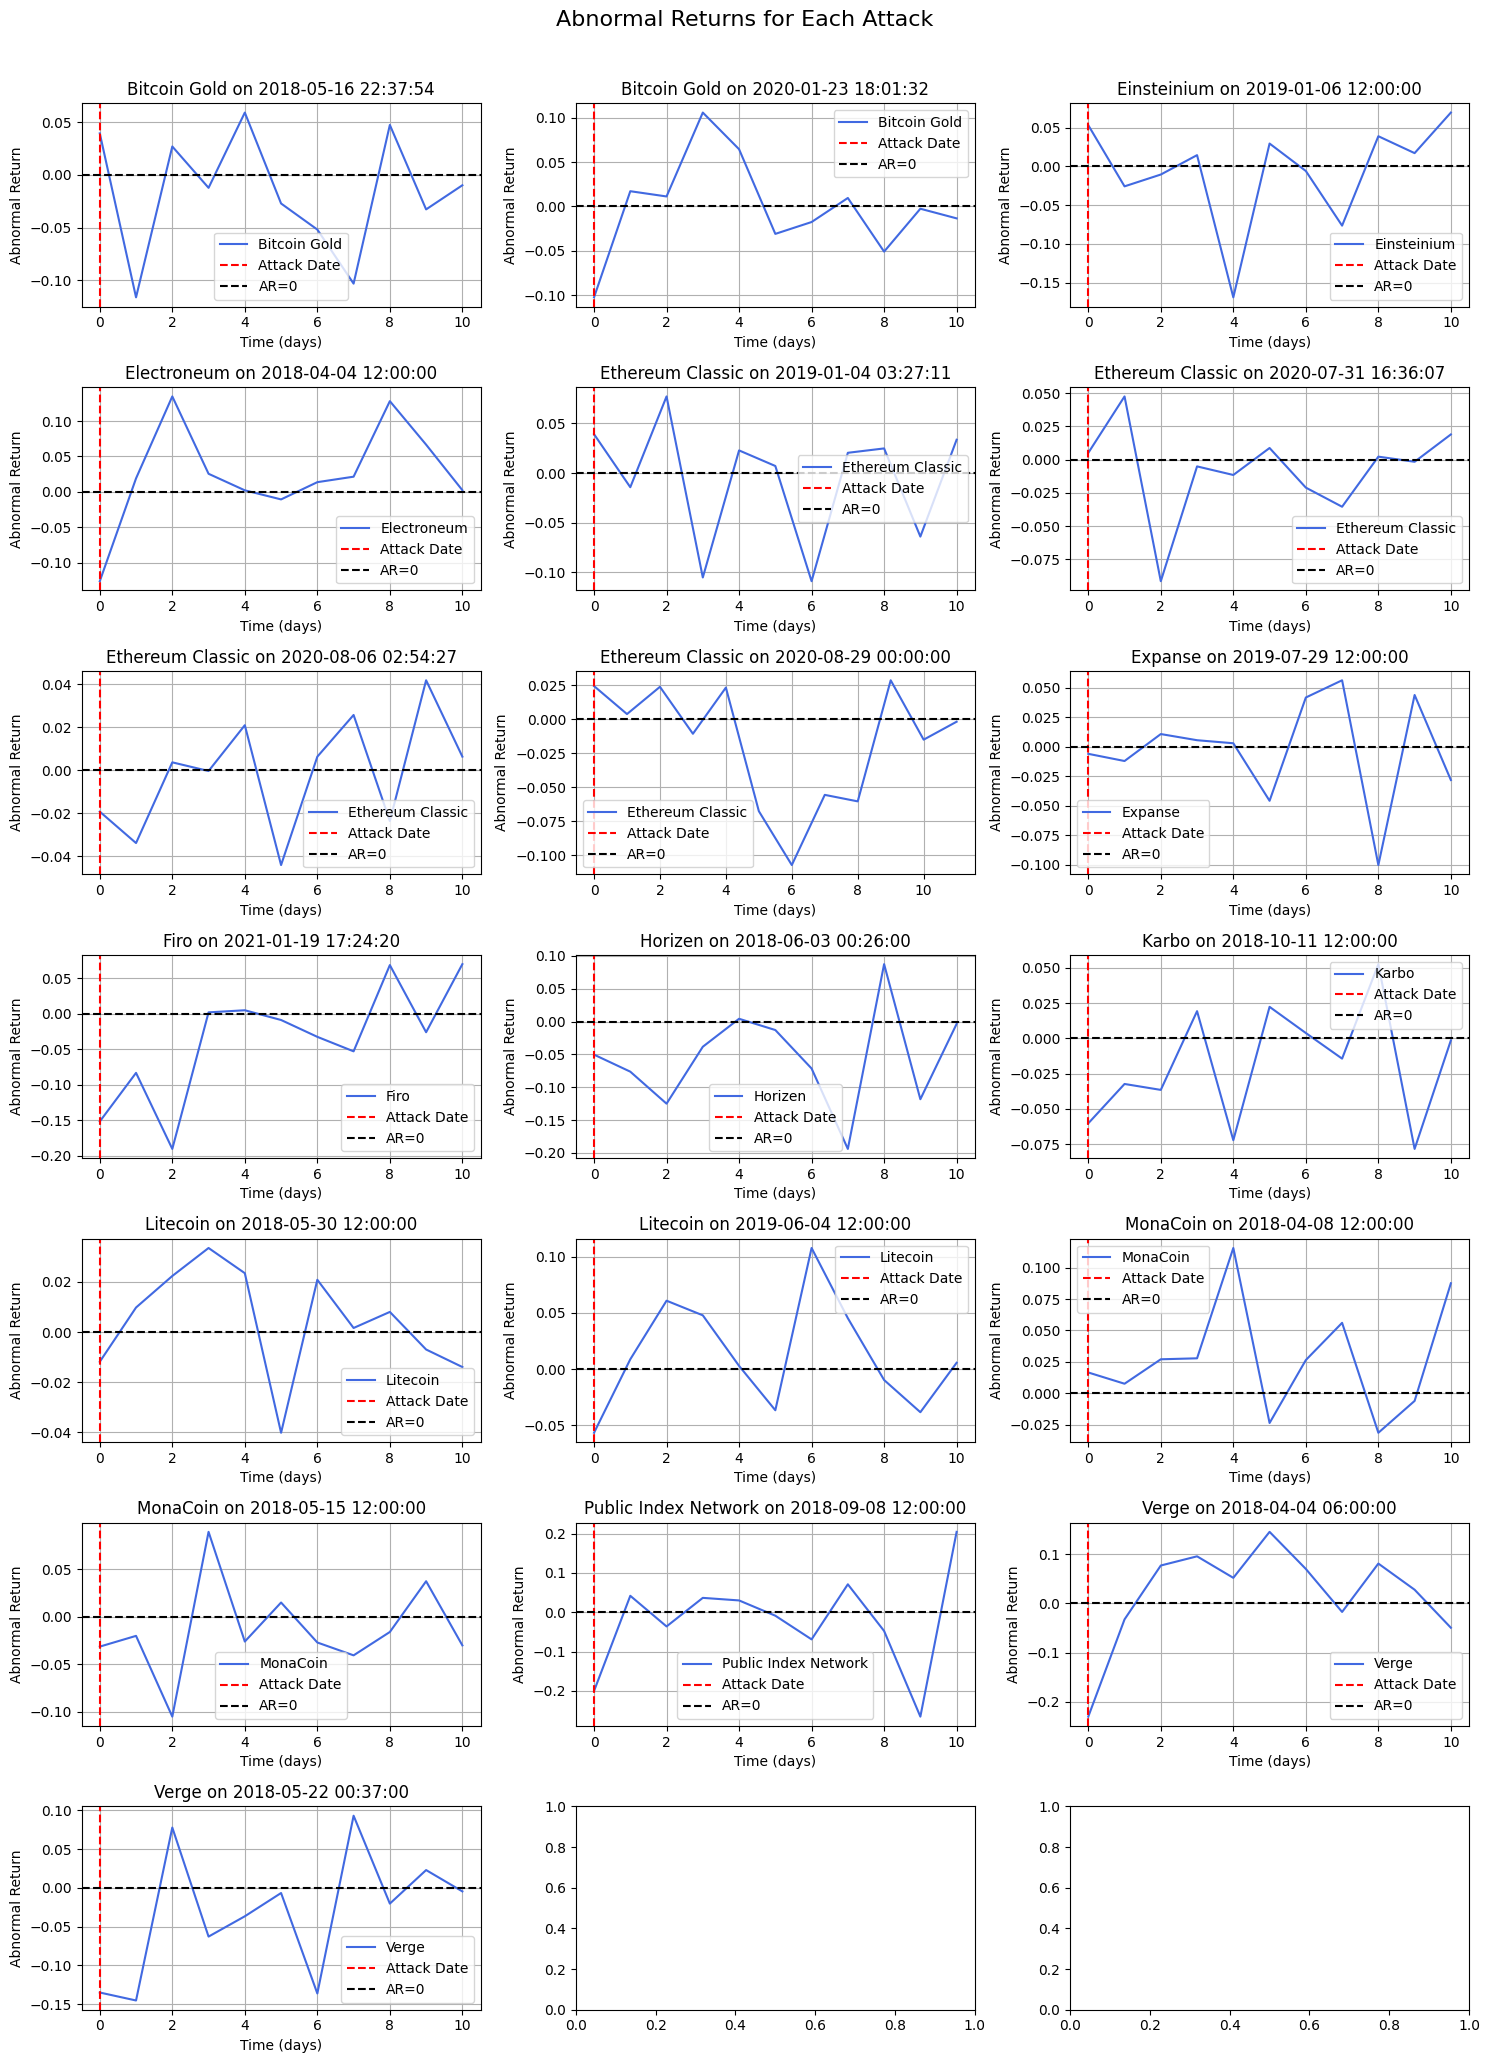

In [14]:
# Testing economic models
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set up the subplot grid with an appropriate size
num_attacks = sum([len(crypto.value.attack_dates) for crypto in Cryptos])
# Set up the subplot grid with 3 columns
cols = 3
rows = math.ceil(num_attacks / cols)
fig1, axs1 = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig1.suptitle("Market model residuals for Each Attack", fontsize=16)
fig2, axs2 = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig2.suptitle("Abnormal Returns for Each Attack", fontsize=16)

# Flatten axs array if there are multiple rows and columns
axs1 = axs1.flatten()
axs2 = axs2.flatten()

horizon = 10
estimation_window_size = 80
result_data = pd.DataFrame()
abnormal_returns = list()

i=0
for crypto in Cryptos:
  for attack_date in crypto.value.attack_dates:
    crypto_data = pd.DataFrame()
    # Sample data
    asset_returns = crypto.value.data['log_returns']
    market_returns = crypto.value.data['market_log_returns']

    # Market Model Example
    mm = MarketModel(asset_returns, market_returns, attack_date, estimation_window_size, horizon)
    mm_data = pd.DataFrame(data=mm.verify_assumptions())
    mm_data['name'] = mm.name
    mm_data['value'] = mm.calculate_CAR()
    test_data = testing_abnormal_returns(mm.abnormal_returns)
    crypto_data = pd.concat([crypto_data,mm_data,test_data])

    crypto_data['crypto_name'] = crypto.value.name
    crypto_data['attack_date'] = attack_date
    result_data = pd.concat([result_data,crypto_data])

    ax1 = axs1[i] if num_attacks > 1 else axs1
    
    # Plot abnormal returns series for the current cryptocurrency
    ax1.plot(mm.residuals.values, color='royalblue', label=f'{crypto.value.name}')
    
    # Set titles and labels
    ax1.set_title(f'{crypto.value.name} on {attack_date}')
    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Residuals")
    ax1.legend()
    ax1.grid(True)

    ax2 = axs2[i] if num_attacks > 1 else axs2
    
    # Plot abnormal returns series for the current cryptocurrency
    ax2.plot(mm.abnormal_returns.values, color='royalblue', label=f'{crypto.value.name}')
    
    # Mark the attack date (assuming it's index 0 for simplicity; otherwise adjust as needed)
    ax2.axvline(x=0, color='red', linestyle='--', label='Attack Date')
    ax2.axhline(y=0, color='black', linestyle='--', label='AR=0')
    
    # Set titles and labels
    ax2.set_title(f'{crypto.value.name} on {attack_date}')
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Abnormal Return")
    ax2.legend()
    ax2.grid(True)

    i+=1

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
    
result_data.to_csv("AR_result_data")

In [19]:
result_data.loc[result_data['name']=='AR_Market_Model',['value','crypto_name','attack_date']].drop_duplicates()

value           crypto_name          attack_date
0 -0.180687          Bitcoin Gold  2018-05-16 22:37:54
0 -0.009098          Bitcoin Gold  2020-01-23 18:01:32
0 -0.064796           Einsteinium  2019-01-06 12:00:00
0  0.277544           Electroneum  2018-04-04 12:00:00
0 -0.067822      Ethereum Classic  2019-01-04 03:27:11
0 -0.083534      Ethereum Classic  2020-07-31 16:36:07
0 -0.016814      Ethereum Classic  2020-08-06 02:54:27
0 -0.213979      Ethereum Classic  2020-08-29 00:00:00
0 -0.030517               Expanse  2019-07-29 12:00:00
0 -0.398614                  Firo  2021-01-19 17:24:20
0 -0.598902               Horizen  2018-06-03 00:26:00
0 -0.197947                 Karbo  2018-10-11 12:00:00
0  0.046540              Litecoin  2018-05-30 12:00:00
0  0.137881              Litecoin  2019-06-04 12:00:00
0  0.303309              MonaCoin  2018-04-08 12:00:00
0 -0.153401              MonaCoin  2018-05-15 12:00:00
0 -0.242887  Public Index Network  2018-09-08 12:00:00
0  0.216542                 Verge  2018-04-04 06:00:00
0 -0.352565                 Verge  2018-05-22 00:37:00

**OBSERVATION**

- We can observe that the order of magnitude of the abnormal return is that of the residuals, as the returns are very volatile. This confirms our concerns that the rigidity of the market model may prevent the abnormal return from being significant. When looking at the residuals, we find that the abnormal returns are quite similar to what would be considered normal, which complicates the analysis.

### Studying 51% attacks using the LP method

{'stationarity': True, 'autocorrelation': np.False_, 'heteroskedasticity': np.True_}


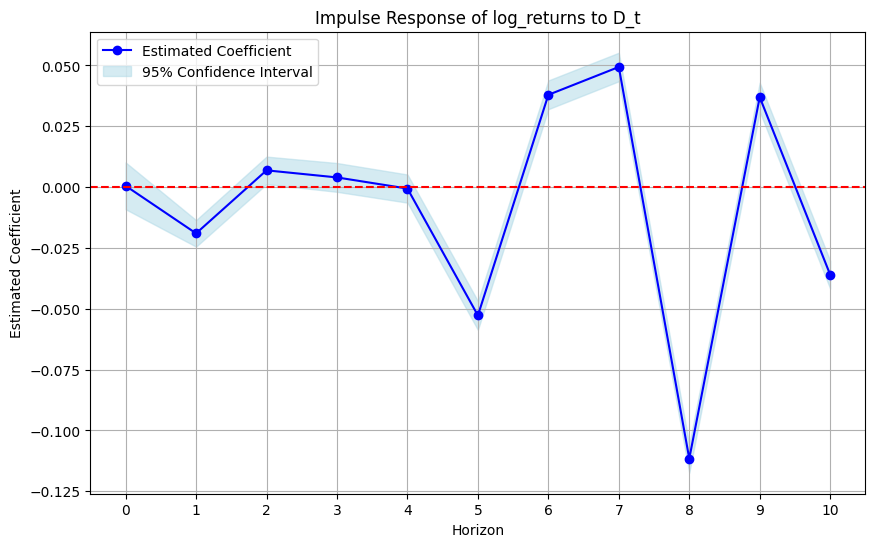

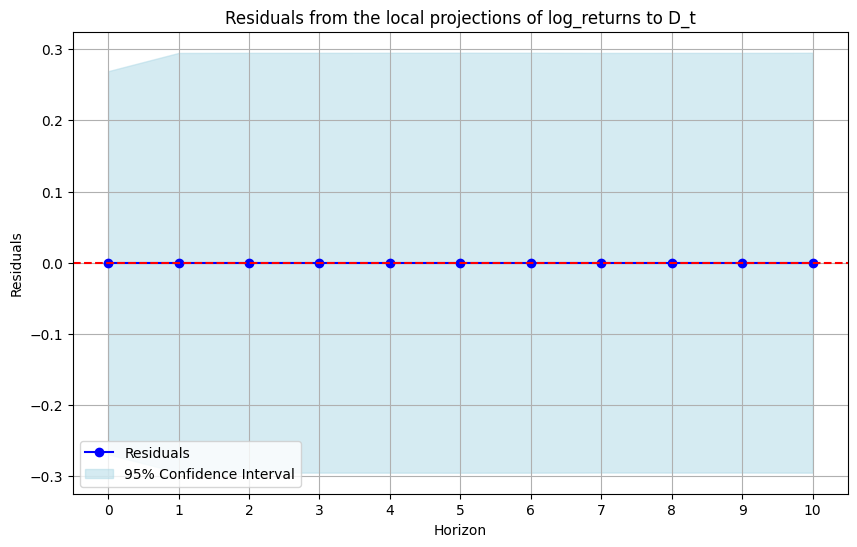

Horizon 0 - Durbin-Watson statistic: 2.0108397942989256
Horizon 0 - Ljung-Box test:
     lb_stat  lb_pvalue
10  4.170123   0.939346

Horizon 1 - Durbin-Watson statistic: 2.748280741560389
Horizon 1 - Ljung-Box test:
     lb_stat     lb_pvalue
10  206.2907  7.854803e-39

Horizon 2 - Durbin-Watson statistic: 2.76403614926699
Horizon 2 - Ljung-Box test:
       lb_stat     lb_pvalue
10  215.308649  1.024521e-40

Horizon 3 - Durbin-Watson statistic: 2.761941078906202
Horizon 3 - Ljung-Box test:
       lb_stat     lb_pvalue
10  213.515258  2.429735e-40

Horizon 4 - Durbin-Watson statistic: 2.763911734204678
Horizon 4 - Ljung-Box test:
       lb_stat     lb_pvalue
10  213.618491  2.311925e-40

Horizon 5 - Durbin-Watson statistic: 2.7635155034007695
Horizon 5 - Ljung-Box test:
       lb_stat     lb_pvalue
10  213.480379  2.470880e-40

Horizon 6 - Durbin-Watson statistic: 2.7614247879969076
Horizon 6 - Ljung-Box test:
       lb_stat     lb_pvalue
10  210.337191  1.121674e-39

Horizon 7 - Durbin

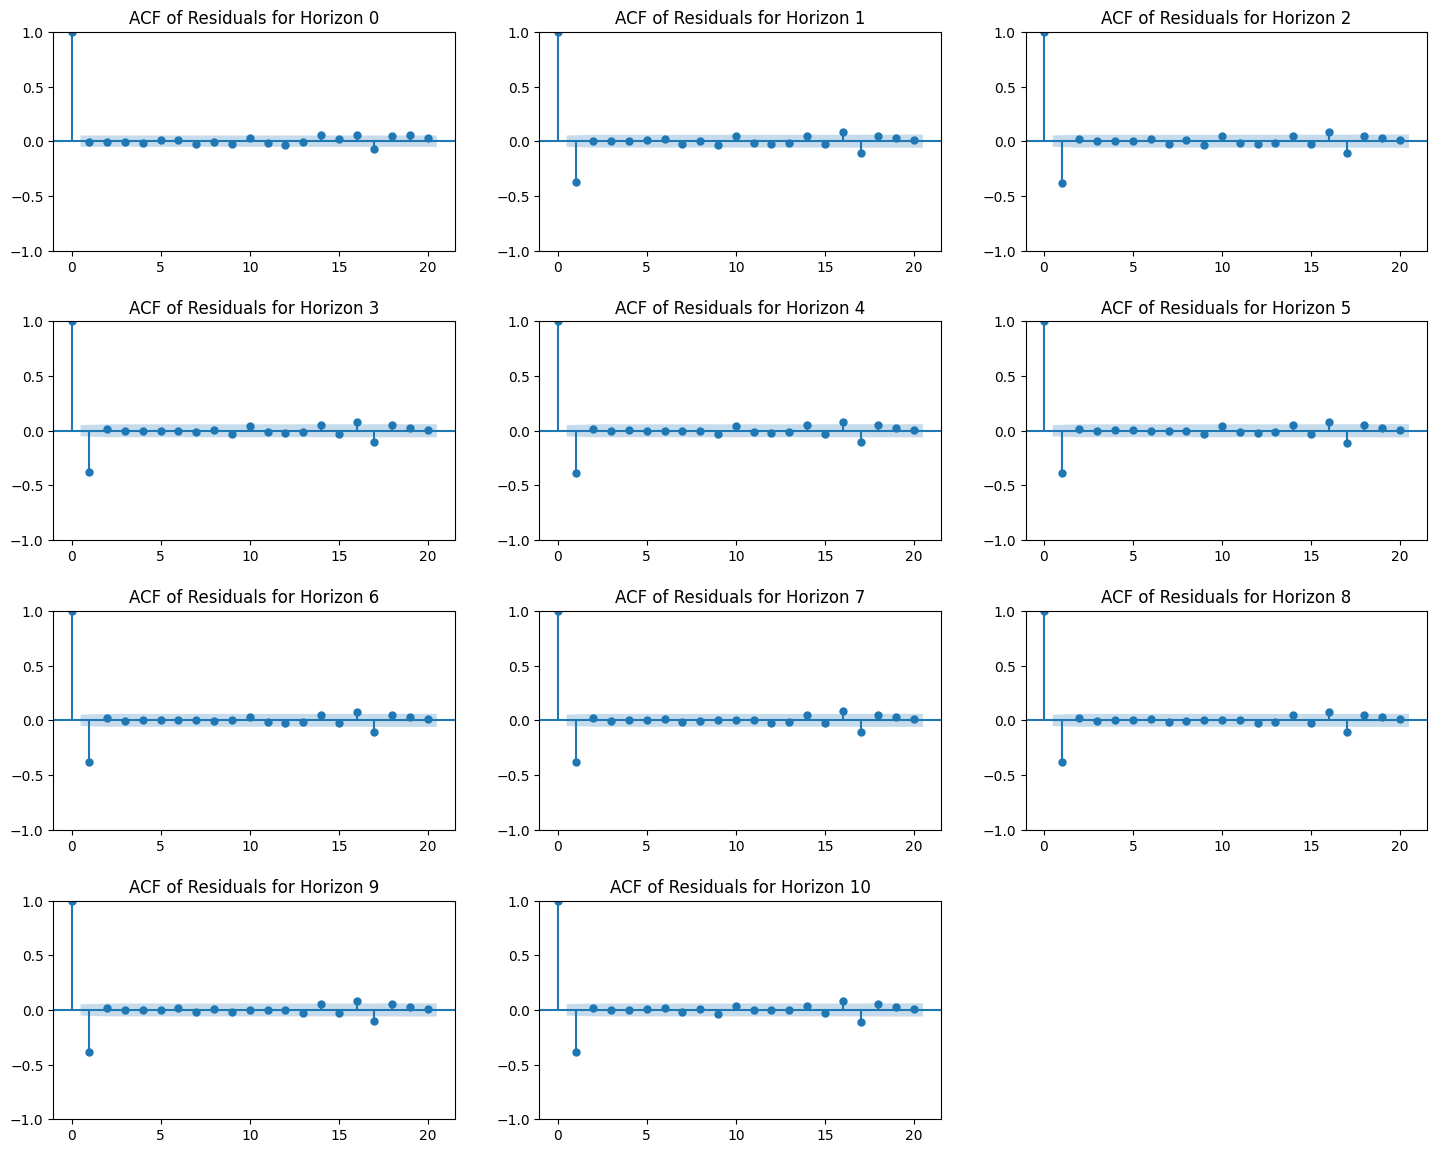

In [13]:
# Local projections
from local_projections import LocalProjectionsModel
dates = Cryptos.EXP.value.data.index
returns = Cryptos.EXP.value.data.log_returns
market_returns = Cryptos.EXP.value.data.market_log_returns

data = pd.DataFrame({
    'date': dates,
    'log_returns': returns,
    'market_log_returns': market_returns
})

event_dates = [Cryptos.EXP.value.attack_dates[0]]

# Initialize the Local Projections Model
dependent_var = 'log_returns'
shock_var = 'D_t'
control_vars = ['market_log_returns']
model = LocalProjectionsModel(data, dependent_var, shock_var, control_vars)

# Construct local projection data
horizon = 10
num_lags = 3
lp_data = model.construct_local_projection_data(event_dates, num_lags)
ifs = model.run_local_projections(event_dates, horizon, num_lags=num_lags,)

# Validate assumptions
assumption_checks = model.validate_assumptions()
print(assumption_checks)
# Plot the results
model.plot_projections()
residuals = model.residuals.dropna()

# Define the number of rows needed based on the horizon+1 and 3 columns
n_residuals = horizon + 1
n_cols = 3
n_rows = math.ceil(n_residuals / n_cols)

# Create the figure with the calculated number of rows and 3 columns
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 3))
fig.tight_layout(pad=3.0)

# Flatten the axes array to make it easier to index in the loop
axes = axes.flatten()

for res in range(n_residuals):
    # Calculate the Durbin-Watson statistic
    dw_stat = durbin_watson(residuals[res])
    print(f'Horizon {res} - Durbin-Watson statistic: {dw_stat}')
    
    # Perform the Ljung-Box test
    lb_test = acorr_ljungbox(residuals[res], lags=[10], return_df=True)
    print(f'Horizon {res} - Ljung-Box test:\n{lb_test}\n')
    
    # Plot the ACF for each set of residuals on a separate subplot
    plot_acf(residuals[res], lags=20, ax=axes[res])
    axes[res].set_title(f'ACF of Residuals for Horizon {res}')

# Remove any empty subplots if horizon+1 is not a multiple of 3
for i in range(n_residuals, len(axes)):
    fig.delaxes(axes[i])

plt.show()

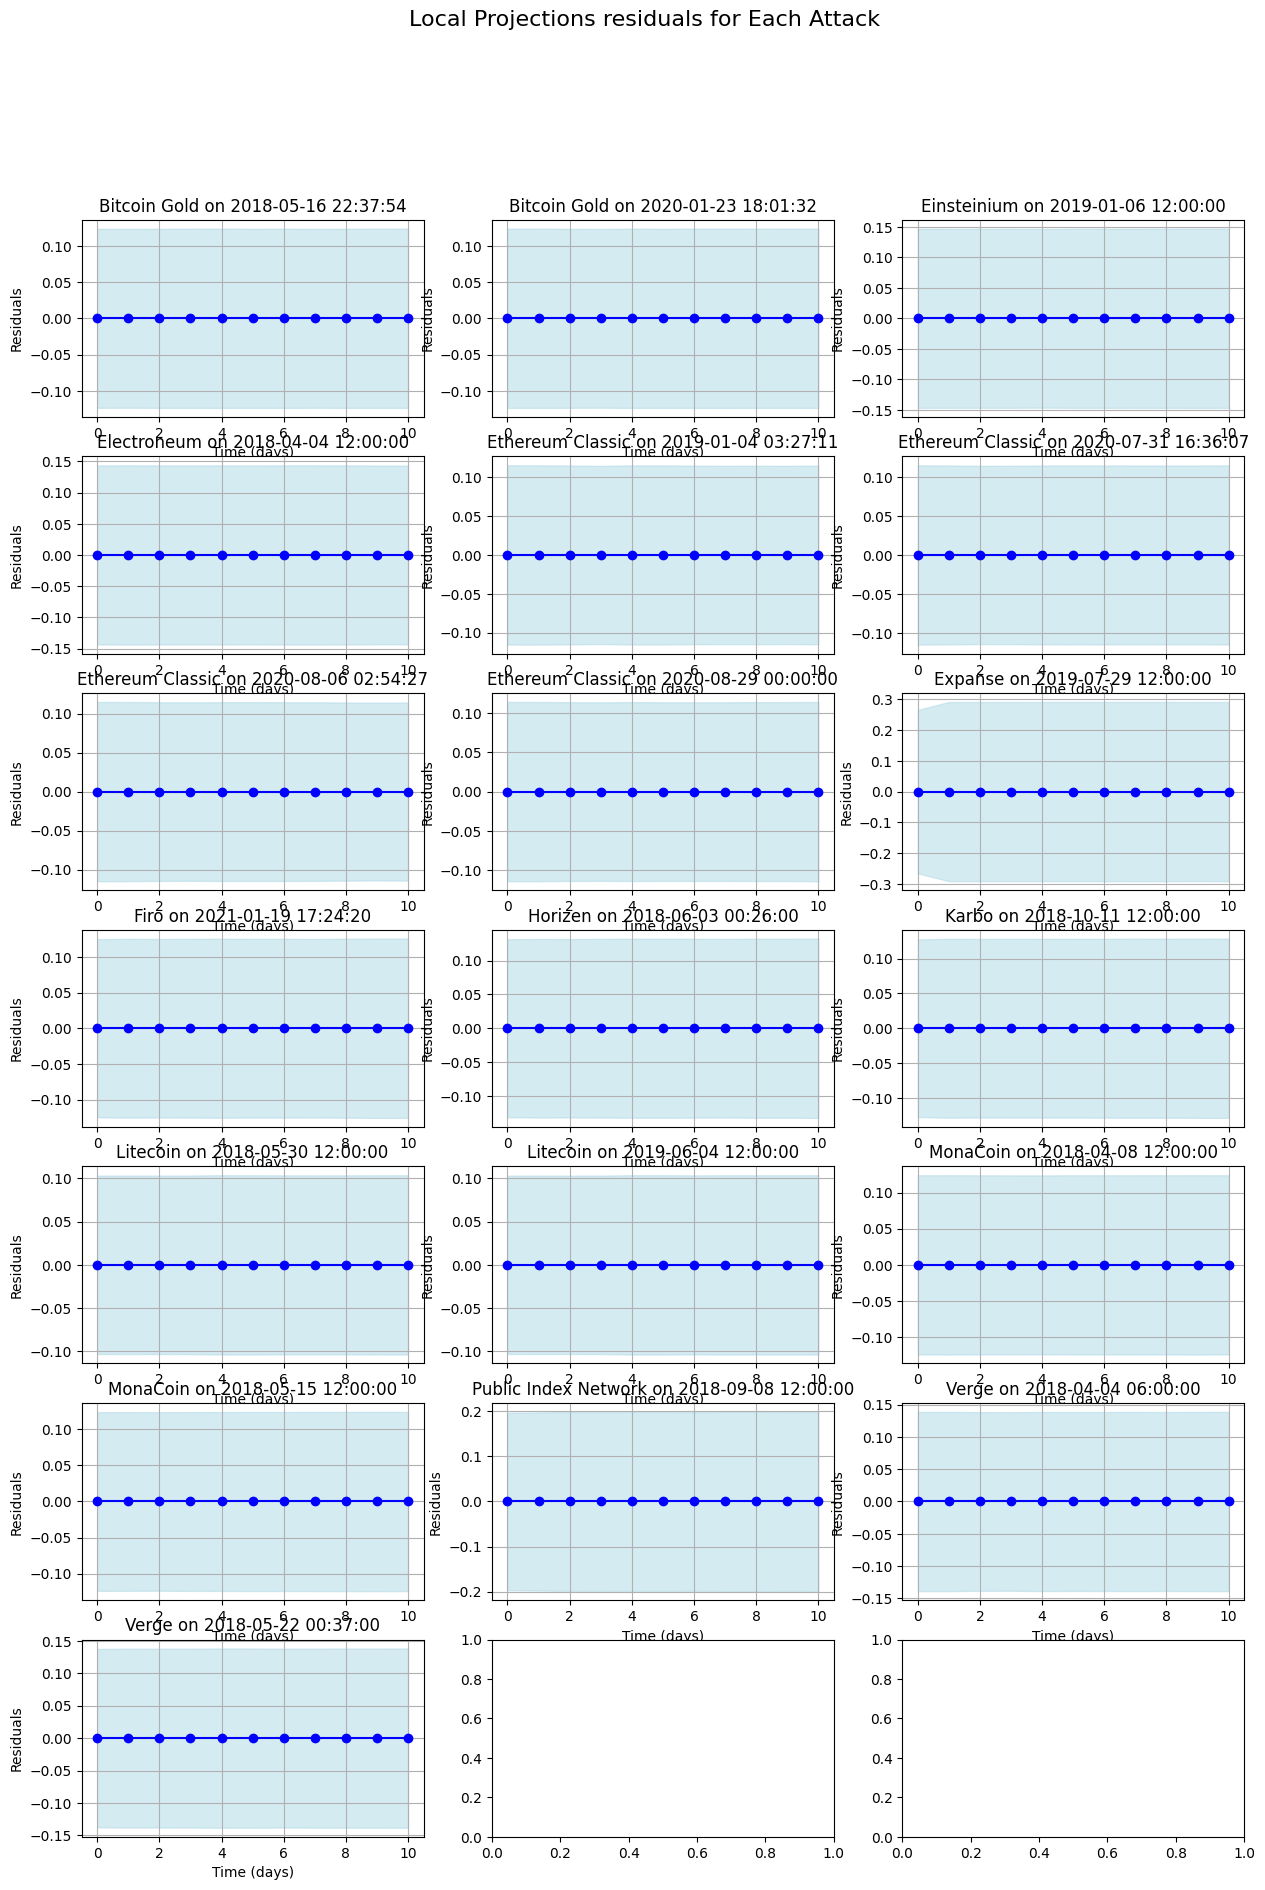

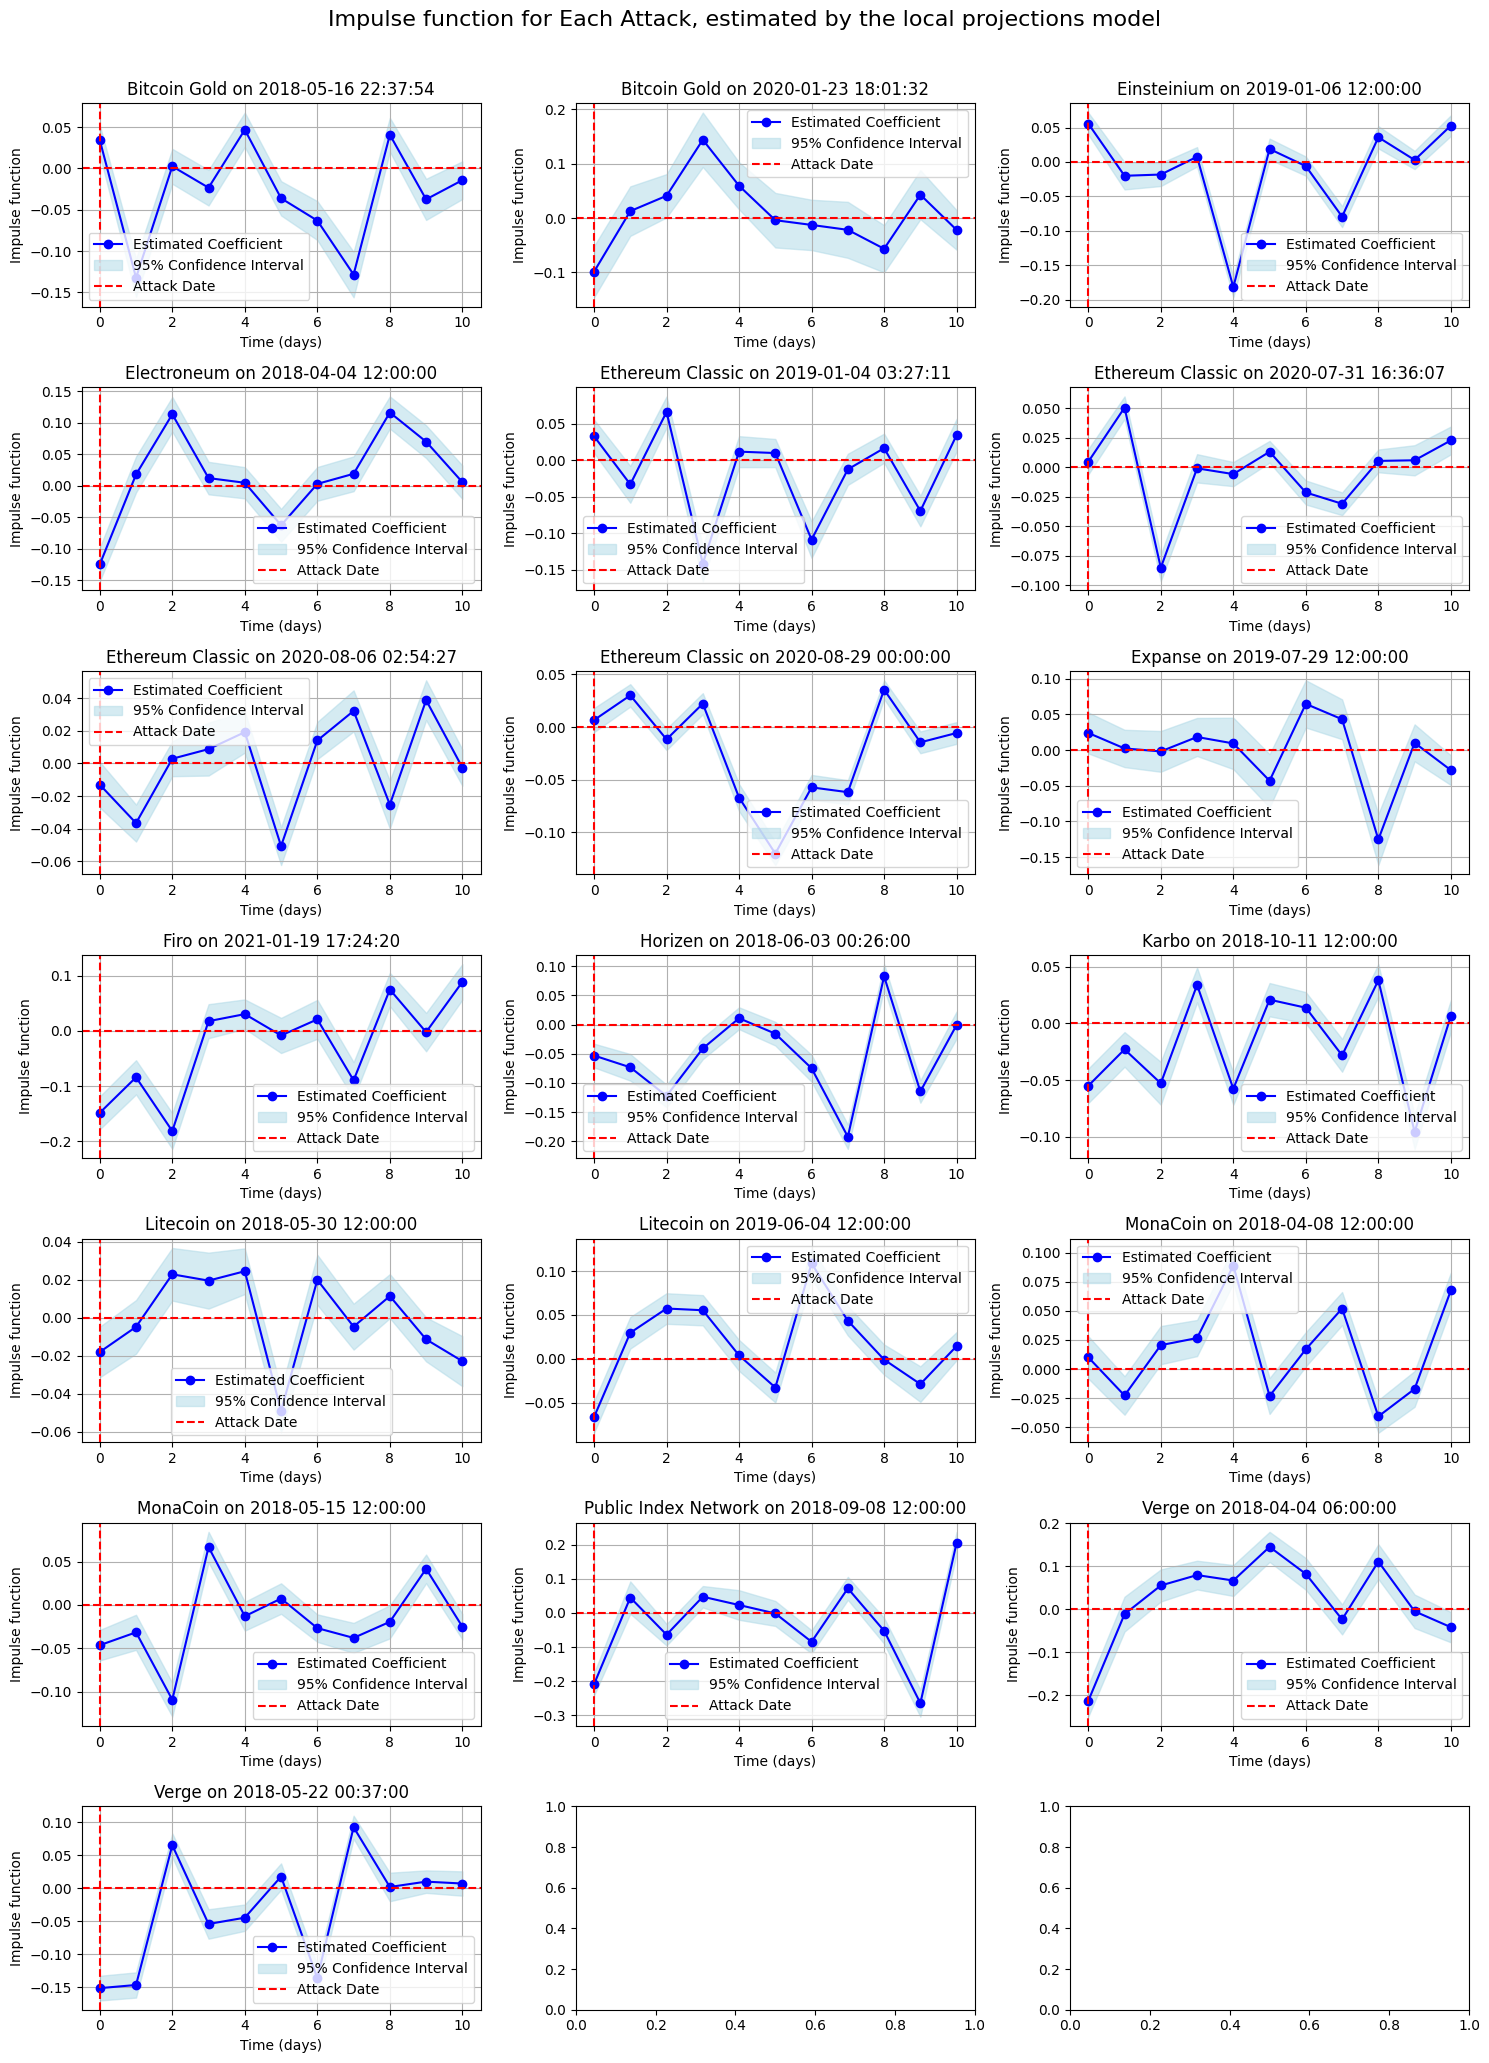

In [8]:
# Fix seed for reproducibility
np.random.seed(42)
# Set up the subplot grid with an appropriate size
num_attacks = sum([len(crypto.value.attack_dates) for crypto in Cryptos])
# Set up the subplot grid with 3 columns
cols = 3
rows = math.ceil(num_attacks / cols)
fig1, axs1 = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig1.suptitle("Local Projections residuals for Each Attack", fontsize=16)
fig2, axs2 = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig2.suptitle("Impulse function for Each Attack, estimated by the local projections model", fontsize=16)

# Flatten axs array if there are multiple rows and columns
axs1 = axs1.flatten()
axs2 = axs2.flatten()

horizon = 10
num_lags = 30
estimation_window_size = 80
result_data = pd.DataFrame()
assumptions_data = pd.DataFrame(columns=['stationarity','autocorrelation','heteroskedasticity','crypto_name','attack_date'])
horizons = list(range(horizon+1))

i=0
for crypto in Cryptos:
  for attack_date in crypto.value.attack_dates:
    crypto_data = pd.DataFrame()

    data = crypto.value.data
    event_dates = [attack_date]

    # Initialize the Local Projections Model
    dependent_var = 'log_returns'
    shock_var = 'D_t'
    market_var = 'market_log_returns'
    model = LocalProjectionsModel(data, dependent_var, shock_var, market_var=market_var)

    lp_data = model.construct_local_projection_data(event_dates, num_lags)

    # Run local projections
    projections = model.run_local_projections(event_dates, horizon, num_lags=num_lags,)
    mean_impact =  projections['Mean_IRF']

    # Validate assumptions
    # mm_data = pd.DataFrame(data=model.validate_assumptions())
    crypto_data = pd.DataFrame(model.validate_assumptions(),index=[i])
    crypto_data['crypto_name'] = crypto.value.name
    crypto_data['attack_date'] = attack_date
    crypto_data['mean_IRF'] = mean_impact.mean()
    crypto_data['min_IRF'] = mean_impact.min()
    crypto_data['max_IRF'] = mean_impact.max()
    crypto_data['std_IRF'] = mean_impact.std()
    assumptions_data = pd.concat([assumptions_data,crypto_data])


    ax1 = axs1[i] if num_attacks > 1 else axs1
    # Convert necessary columns to numeric, setting errors='coerce' to handle any non-numeric values
    projections["Horizon"] = pd.to_numeric(projections["Horizon"], errors='coerce')
    projections["Mean_resid"] = pd.to_numeric(projections["Mean_resid"], errors='coerce')
    projections["LB_resid"] = pd.to_numeric(projections["LB_resid"], errors='coerce')
    projections["UB_resid"] = pd.to_numeric(projections["UB_resid"], errors='coerce')

    # Drop rows where any of the required columns contain NaN values
    projections.dropna(subset=["Horizon", "Mean_resid", "LB_resid", "UB_resid"], inplace=True)

    # Proceed with the plot after cleaning the data
    ax1.plot(projections['Horizon'], projections['Mean_resid'], marker='o', linestyle='-', color='b', label='Estimated Coefficient')
    ax1.fill_between(projections['Horizon'], projections['LB_resid'], projections['UB_resid'], color='lightblue', alpha=0.5, label='95% Confidence Interval')

    # Set titles and labels
    ax1.set_title(f'{crypto.value.name} on {attack_date}')
    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Residuals")
    # ax1.legend()
    ax1.grid(True)

    ax2 = axs2[i] if num_attacks > 1 else axs2
    ax2.plot(projections['Horizon'], mean_impact, marker='o', linestyle='-', color='b', label='Estimated Coefficient')
    ax2.fill_between(projections['Horizon'], projections['LB_IRF'], projections['UB_IRF'], color='lightblue', alpha=0.5, label='95% Confidence Interval')
    ax2.axhline(0, color='r', linestyle='--')
    # Mark the attack date (assuming it's index 0 for simplicity; otherwise adjust as needed)
    ax2.axvline(x=0, color='red', linestyle='--', label='Attack Date')
    # Set titles and labels
    ax2.set_title(f'{crypto.value.name} on {attack_date}')
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Impulse function")
    ax2.legend()
    ax2.grid(True)

    i+=1


# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
    
result_data.to_csv("LP_result_data")
assumptions_data.to_csv("LP_assumptions_data")

#### optimizing the LP model with different AR orders

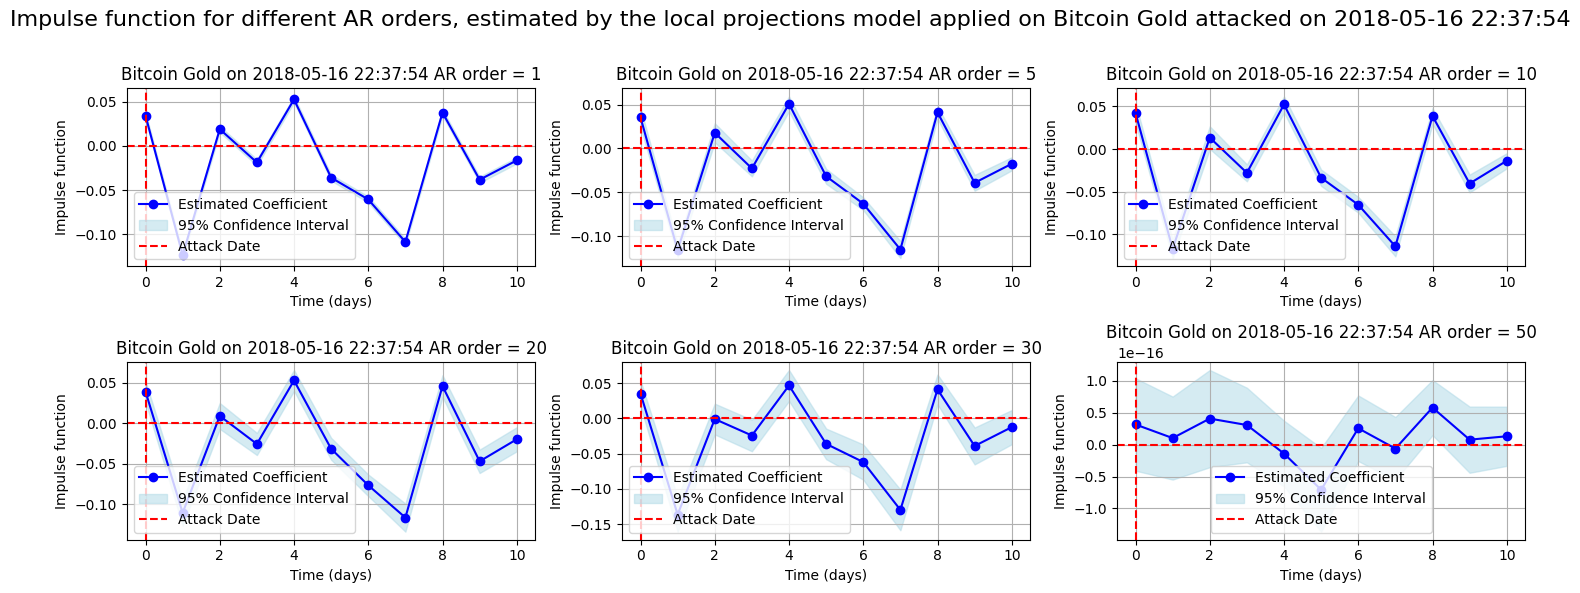

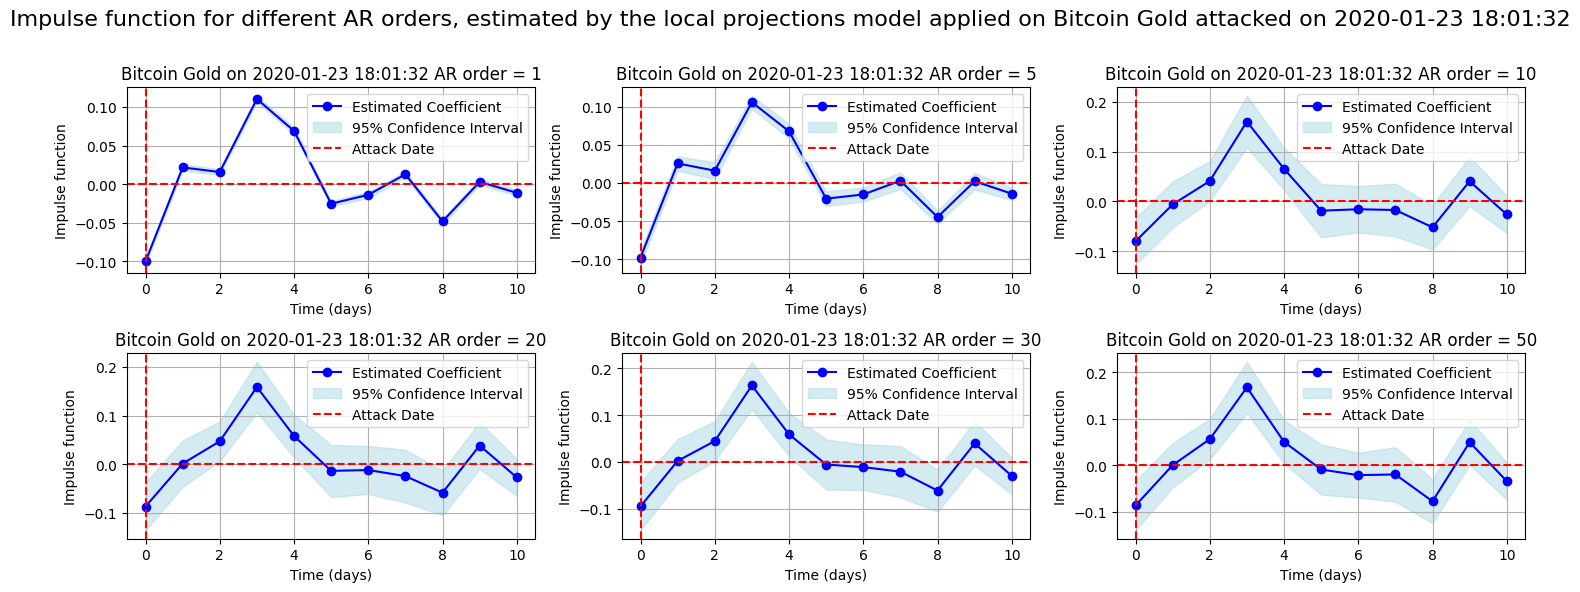

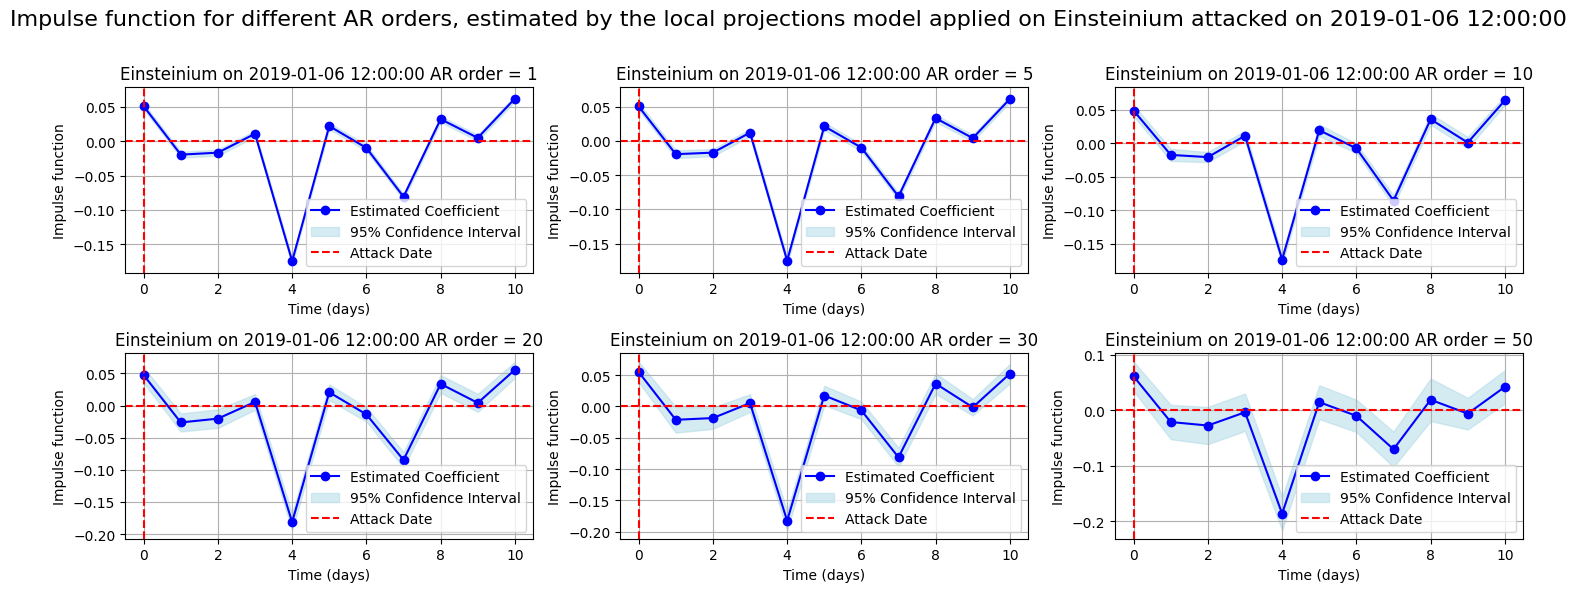

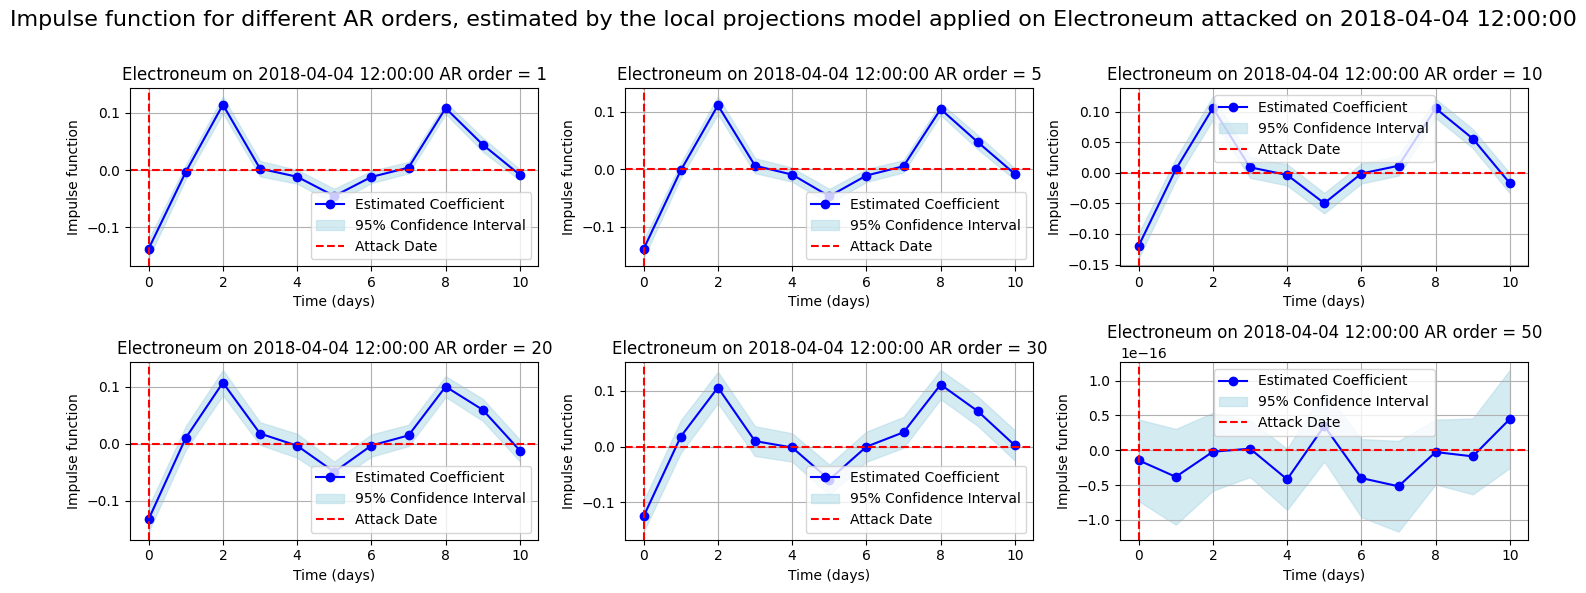

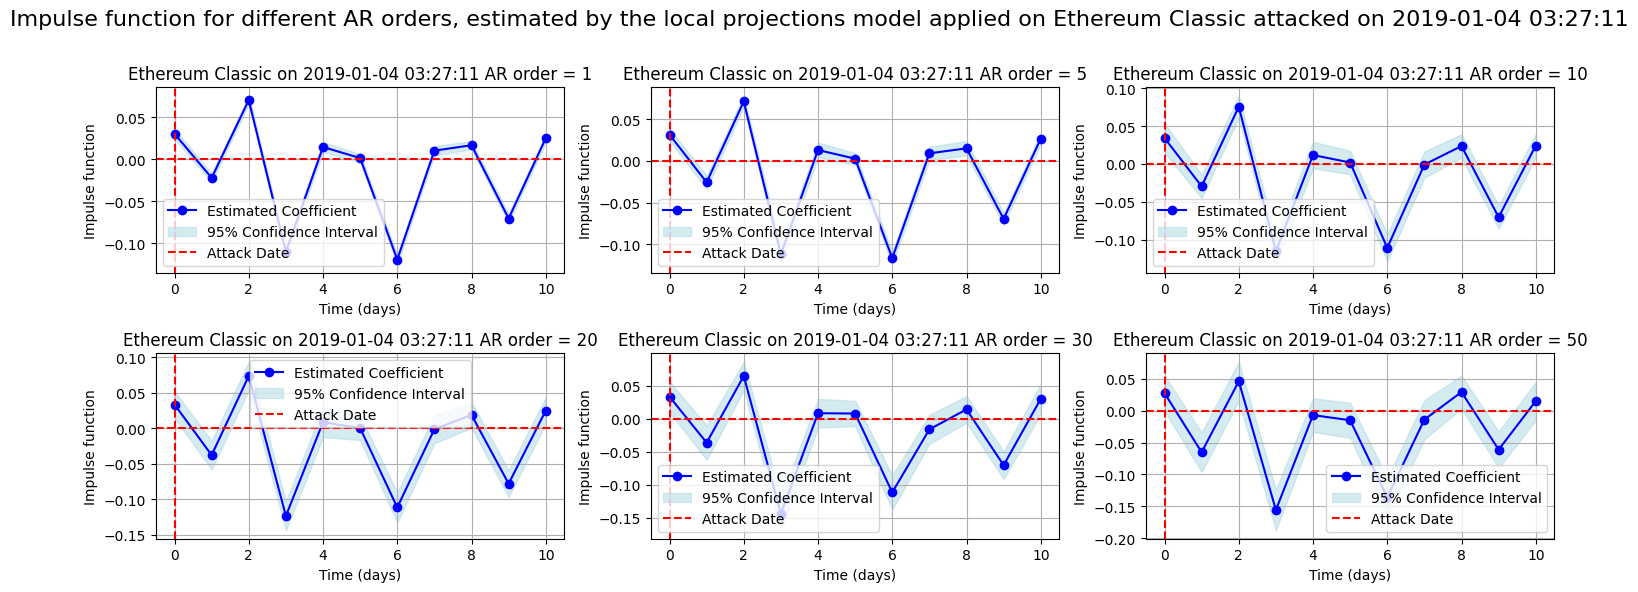

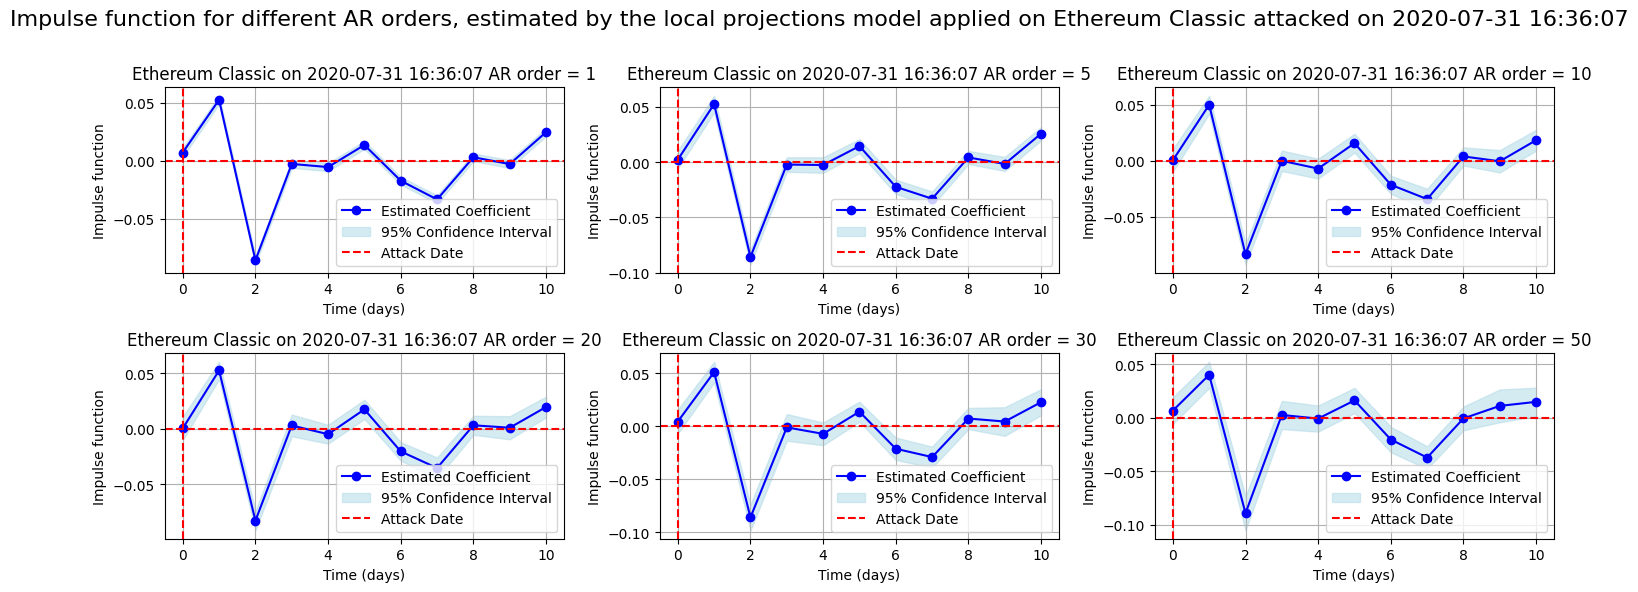

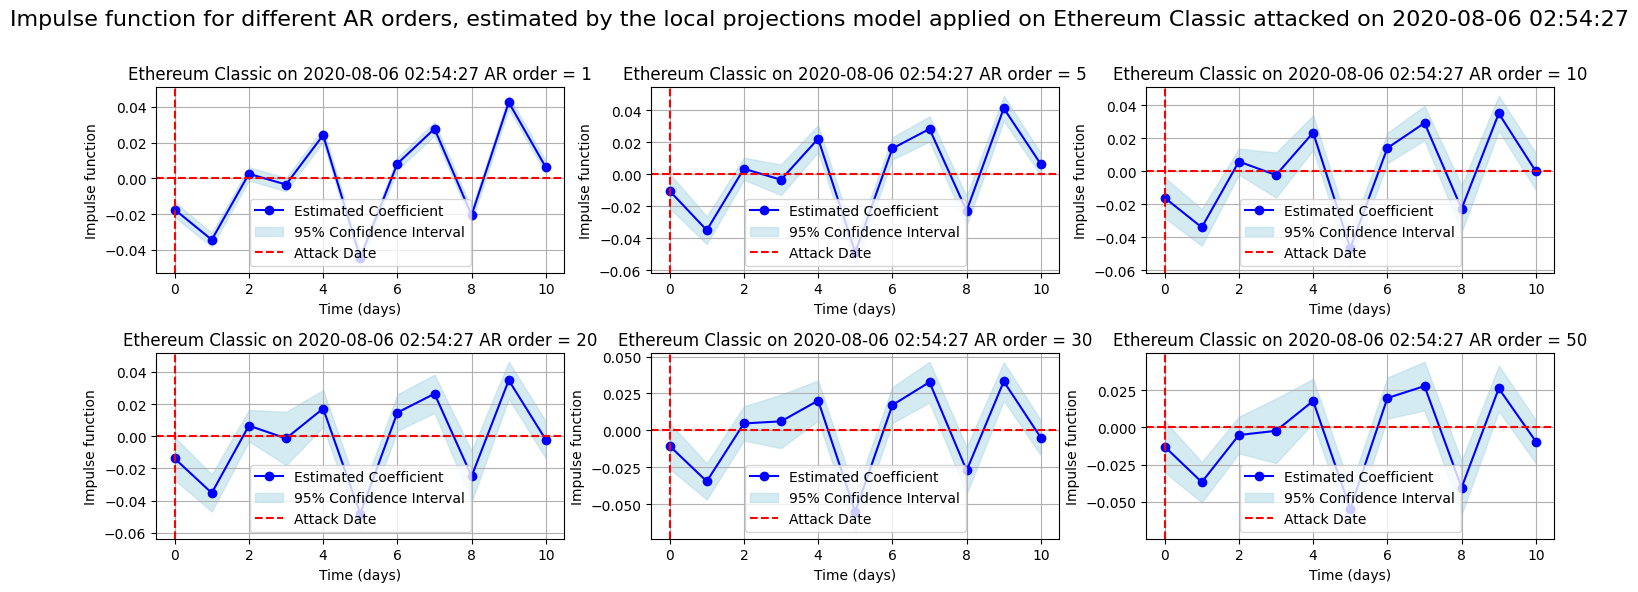

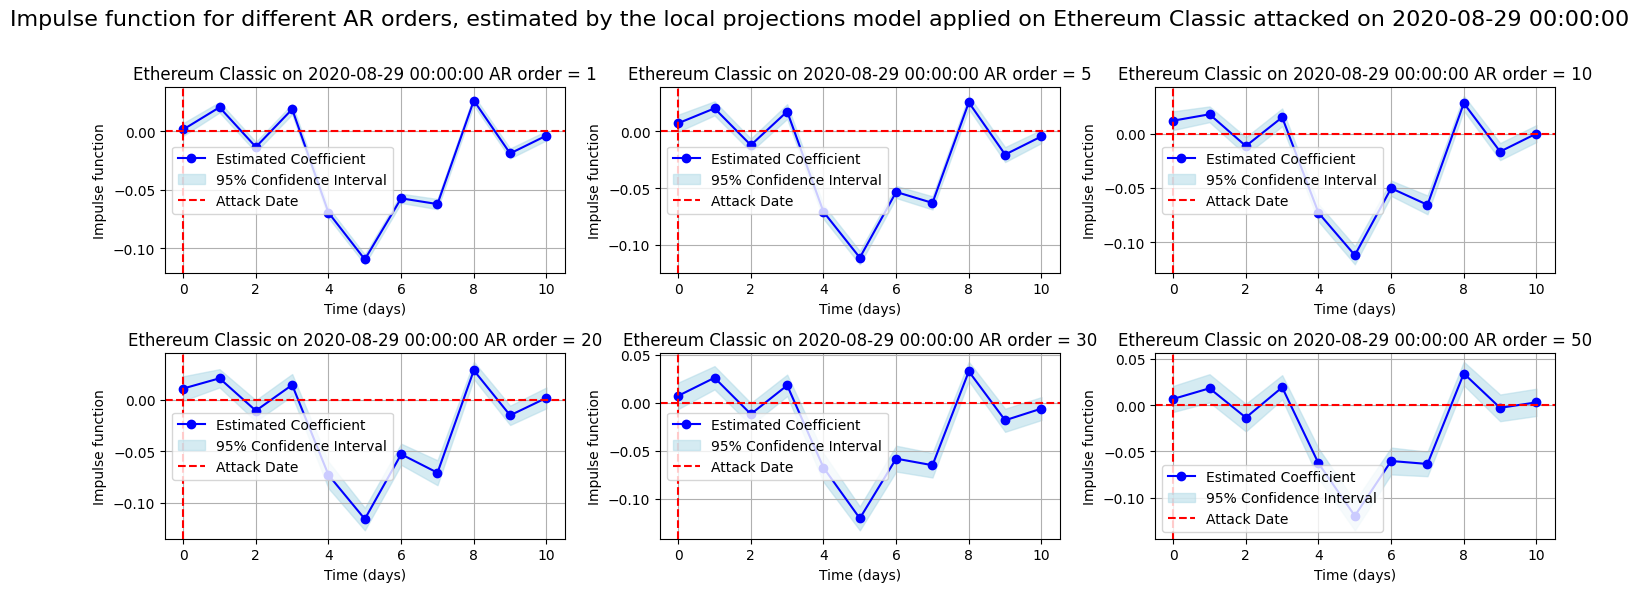

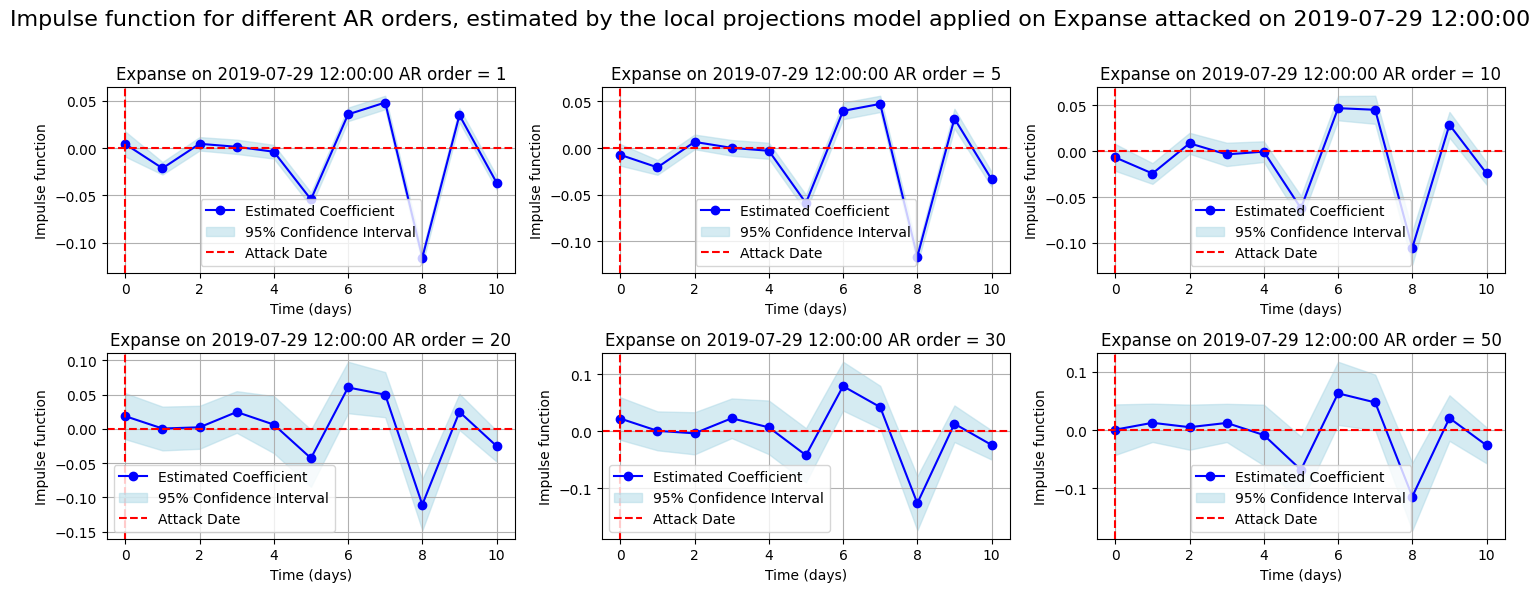

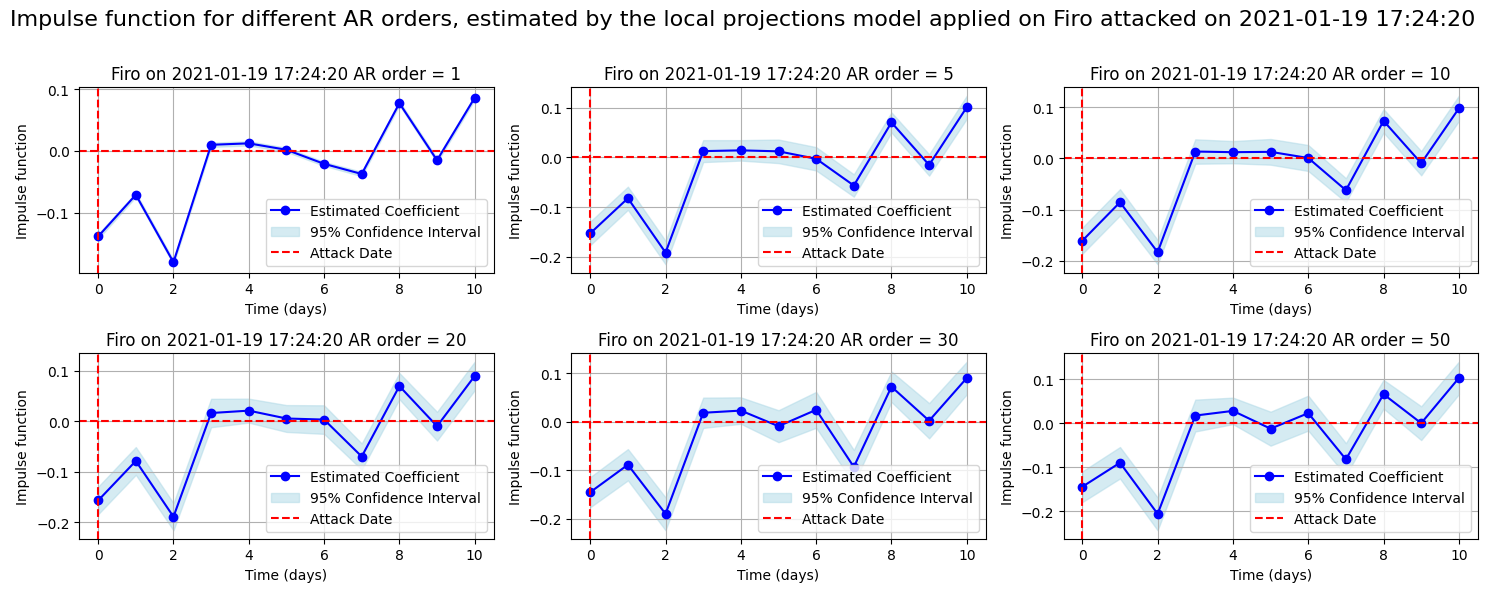

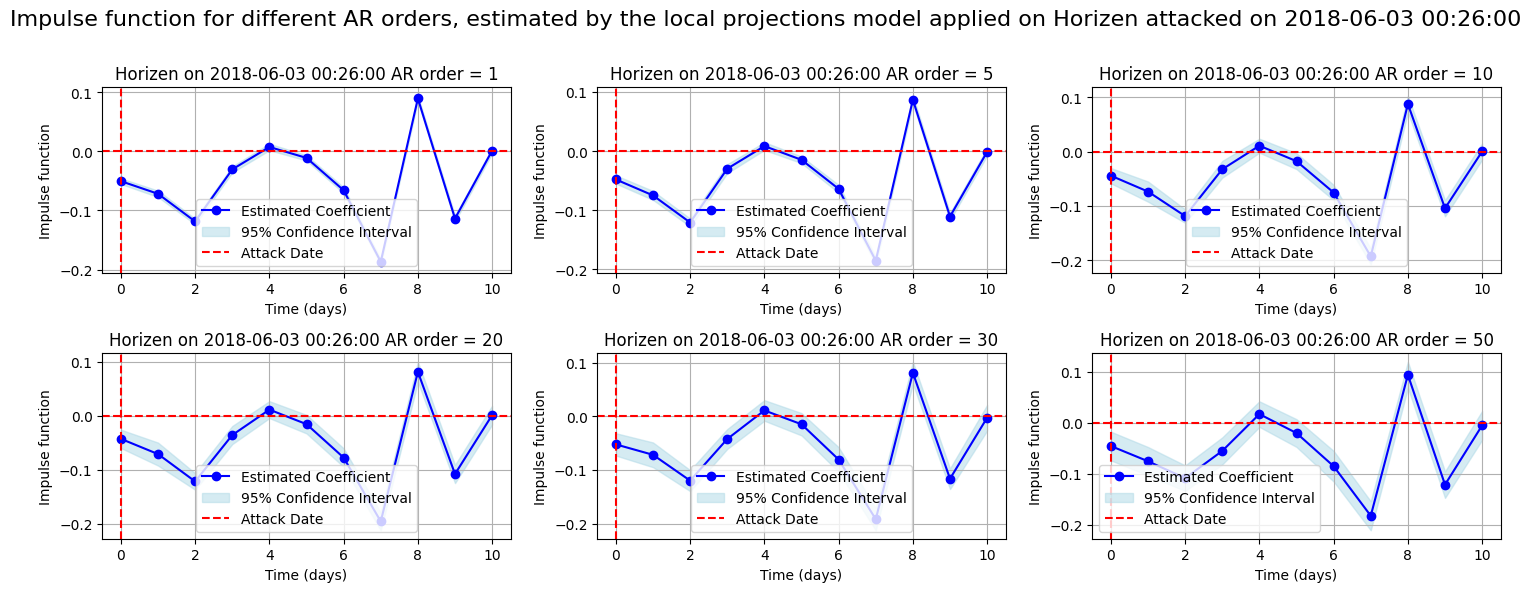

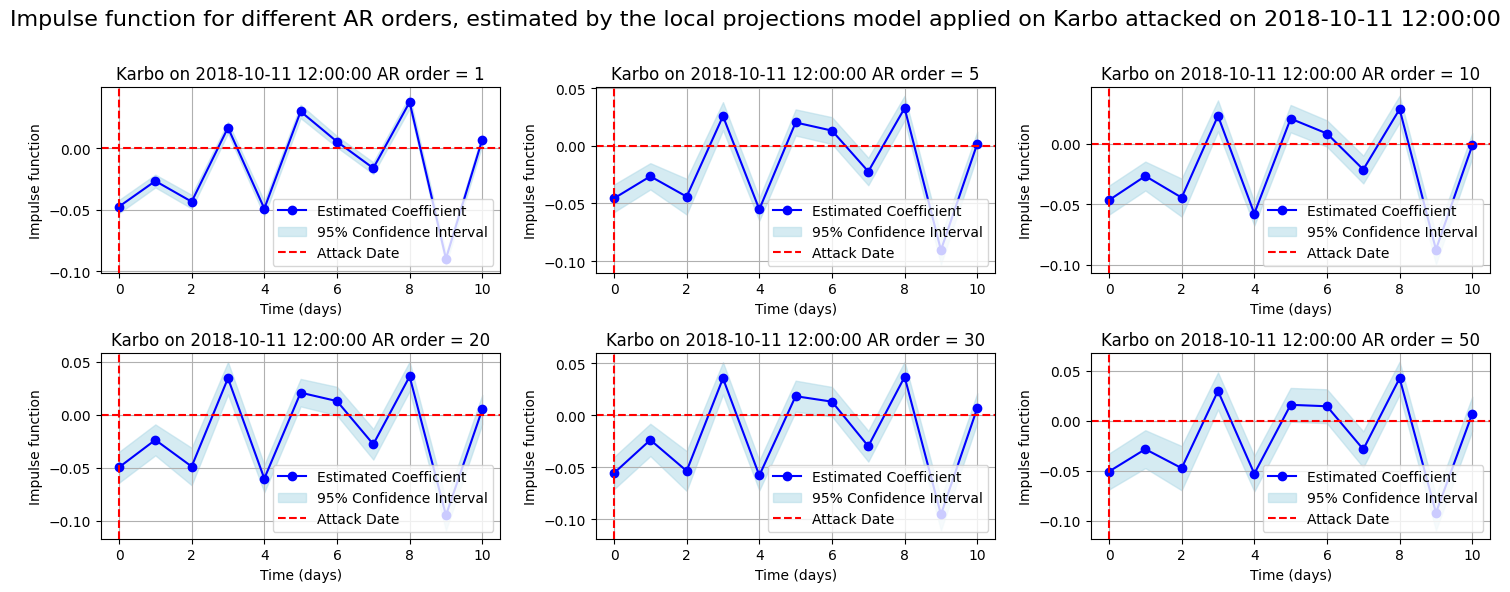

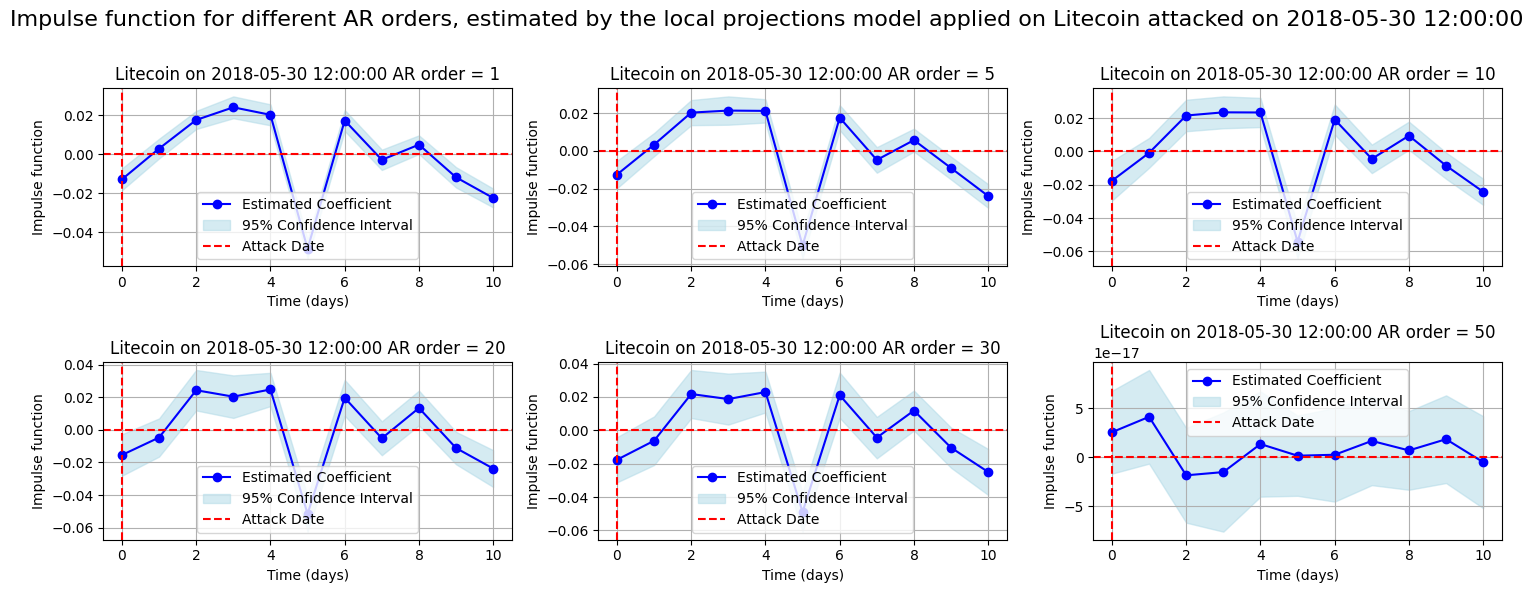

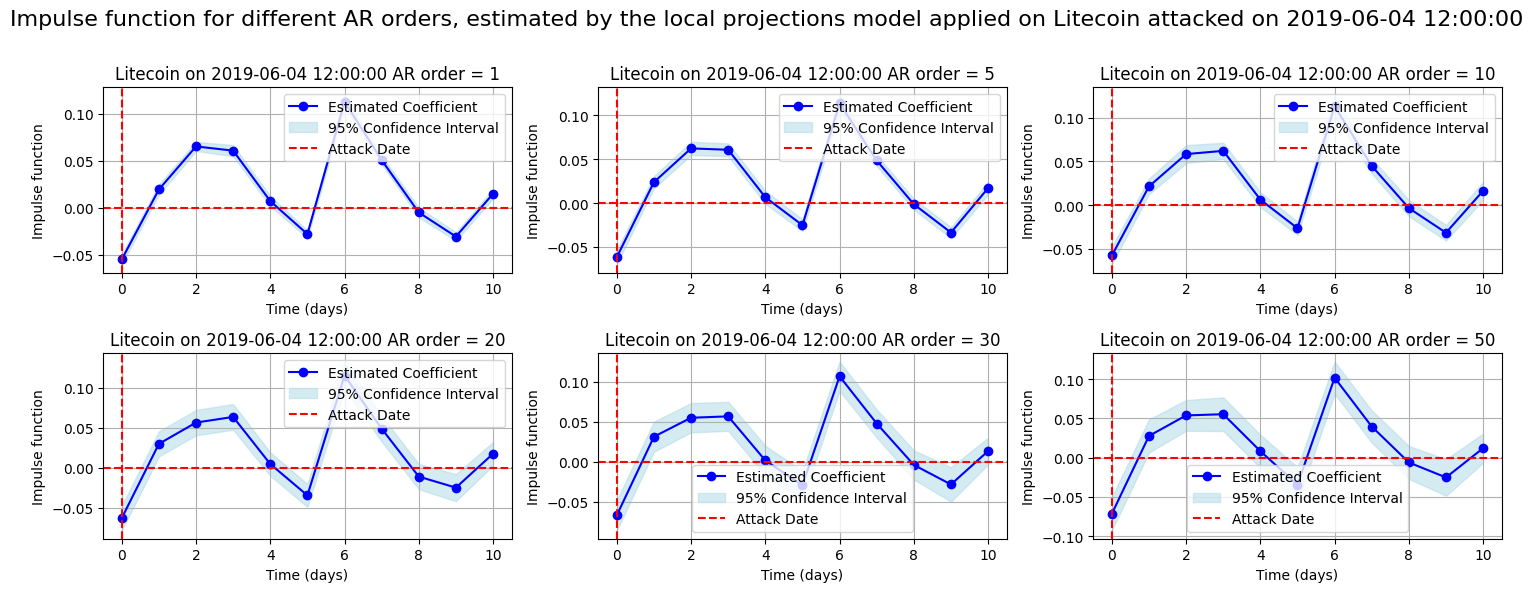

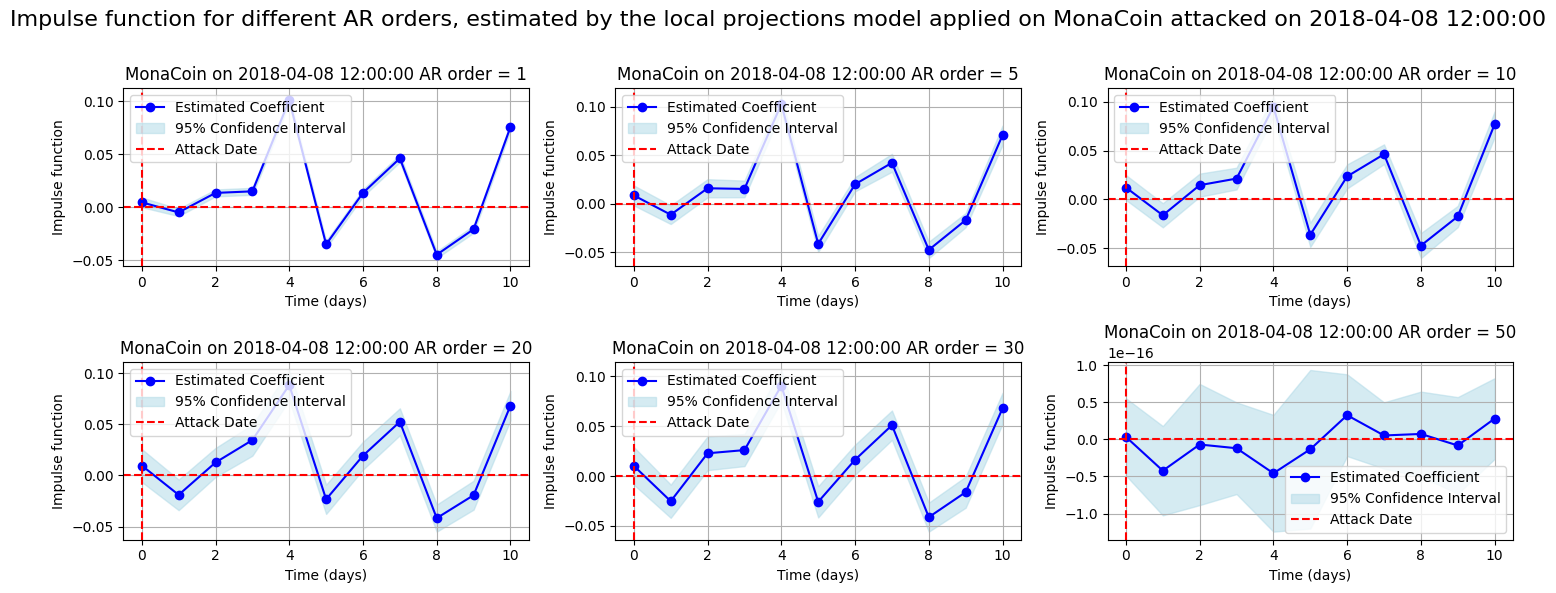

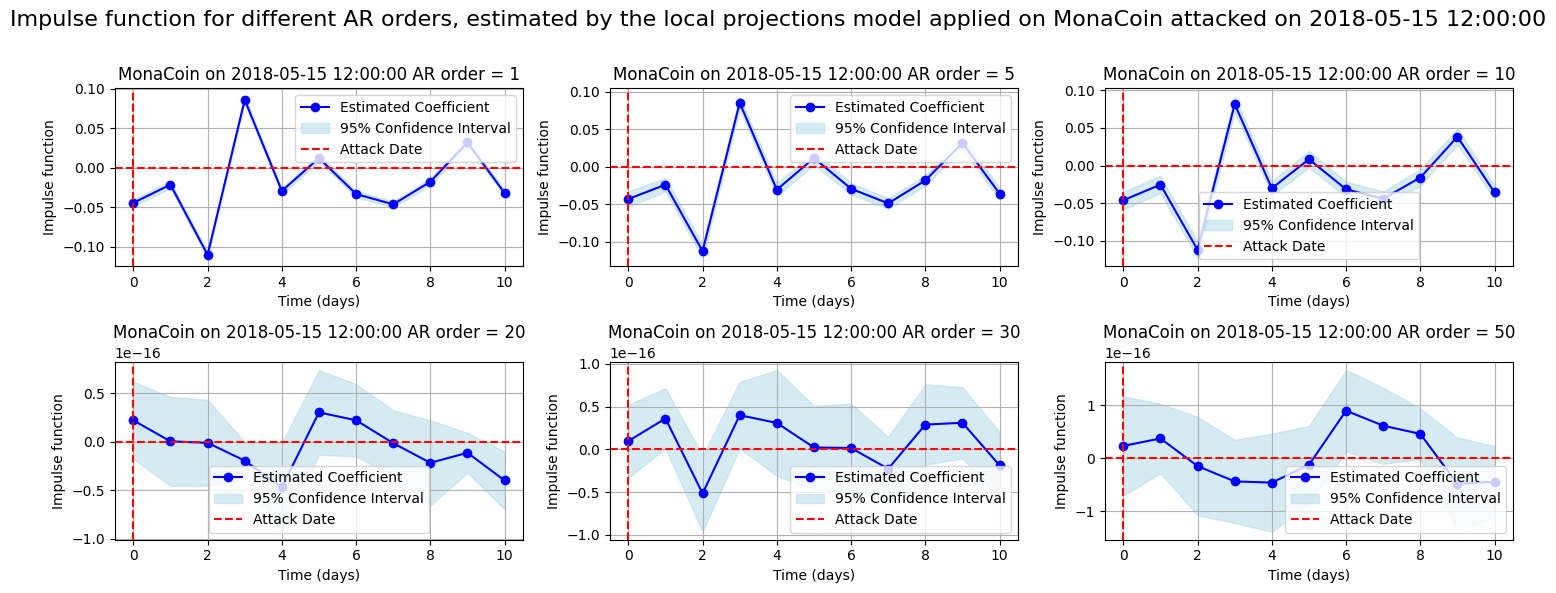

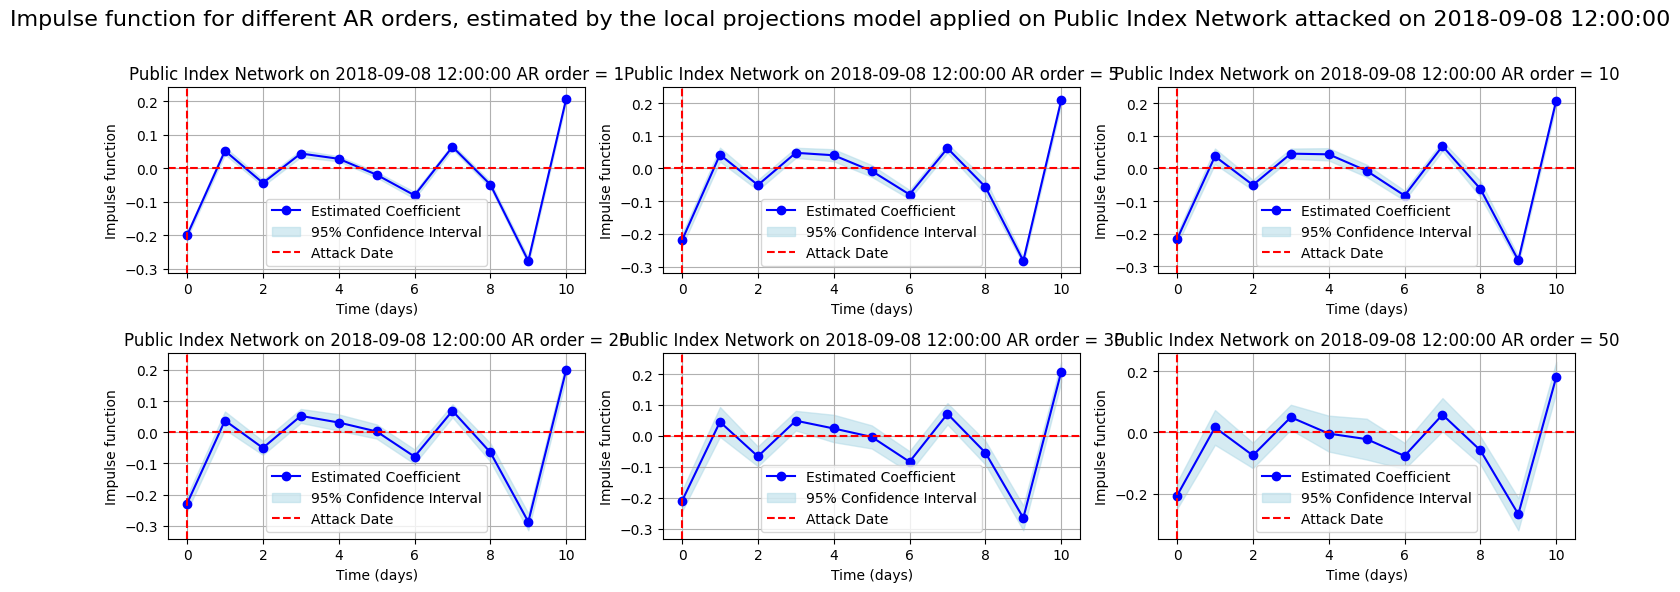

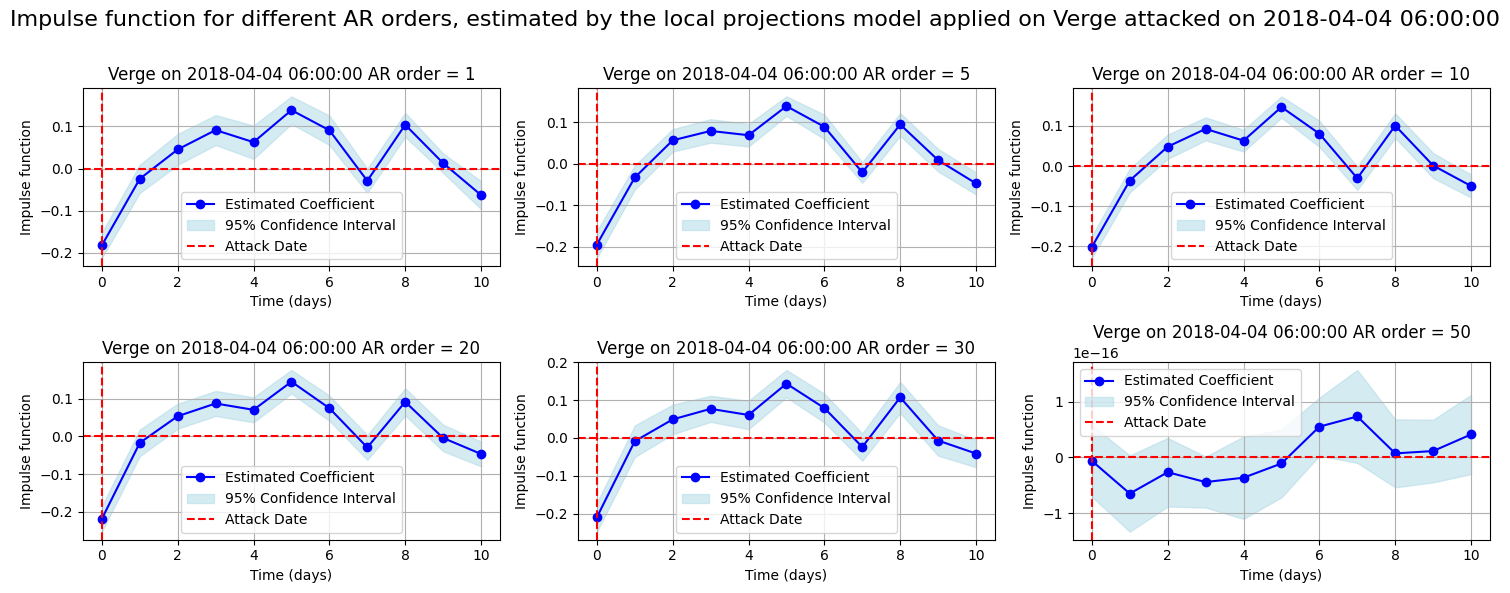

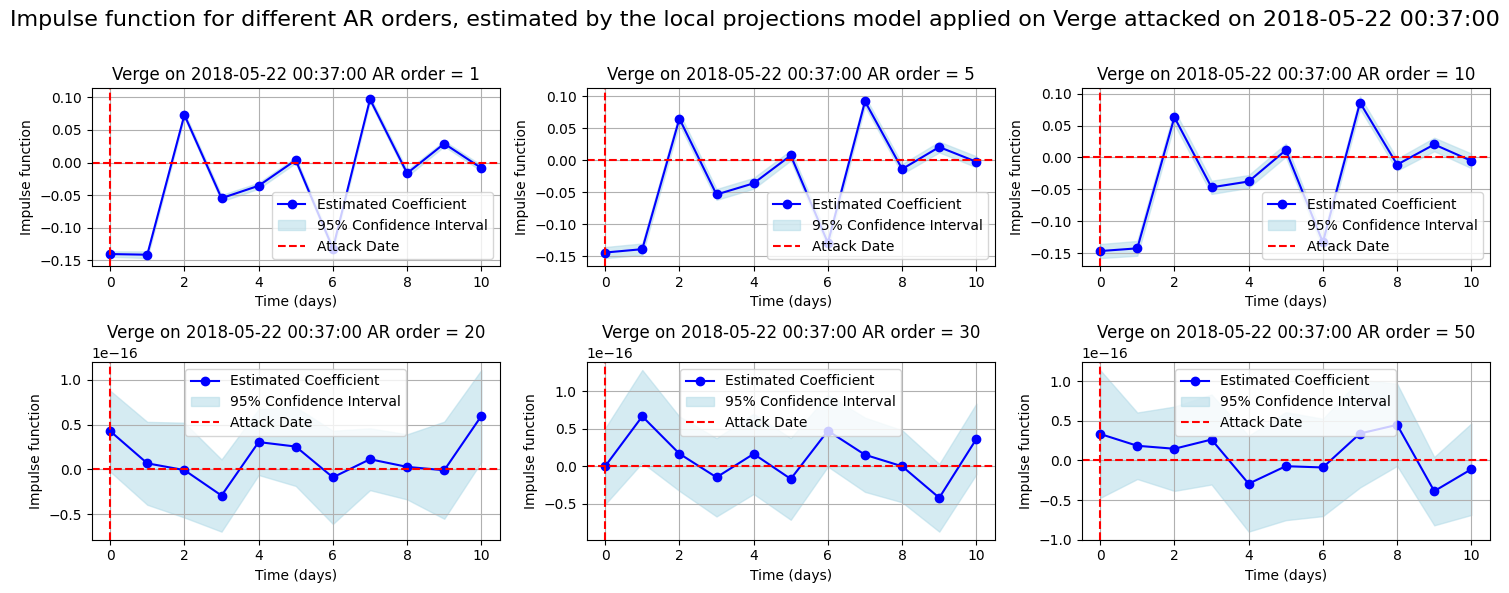

In [14]:
warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)
# crypto = Cryptos.EXP
# attack_date = crypto.value.attack_dates[0]
# Set up the subplot grid with an appropriate size
lags = [1,5,10,20,30,50]
num_lags = len(lags)
estimation_window_size = 80
# Set up the subplot grid with 3 columns
cols = 3
rows = math.ceil(num_lags / cols)
for crypto in Cryptos:
    for attack_date in crypto.value.attack_dates:
        fig2, axs2 = plt.subplots(rows, cols, figsize=(15, rows * 3))
        fig2.suptitle(f"Impulse function for different AR orders, estimated by the local projections model applied on {crypto.value.name} attacked on {attack_date}", fontsize=16)

        # Flatten axs array if there are multiple rows and columns
        axs2 = axs2.flatten()

        horizon = 10
        result_data = pd.DataFrame()
        assumptions_data = pd.DataFrame(columns=['stationarity','autocorrelation','heteroskedasticity','crypto_name','attack_date'])
        horizons = list(range(horizon+1))

        i=0
        for lag in lags:
            crypto_data = pd.DataFrame()

            data = crypto.value.data
            event_dates = [attack_date]

            # Initialize the Local Projections Model
            dependent_var = 'log_returns'
            shock_var = 'D_t'
            market_var = 'market_log_returns'
            model = LocalProjectionsModel(data, dependent_var, shock_var, market_var=market_var)

            lp_data = model.construct_local_projection_data(event_dates, lag)

            # Run local projections
            projections = model.run_local_projections(event_dates, horizon, num_lags=lag,)
            mean_impact =  projections['Mean_IRF']

            # Validate assumptions
            # mm_data = pd.DataFrame(data=model.validate_assumptions())
            lag_data = pd.DataFrame(model.validate_assumptions(),index=[i])
            lag_data['crypto_name'] = crypto.value.name
            lag_data['attack_date'] = attack_date
            lag_data['mean_IRF'] = mean_impact.mean()
            lag_data['min_IRF'] = mean_impact.min()
            lag_data['max_IRF'] = mean_impact.max()
            lag_data['std_IRF'] = mean_impact.std()
            assumptions_data = pd.concat([assumptions_data,crypto_data])

            # Convert necessary columns to numeric, setting errors='coerce' to handle any non-numeric values
            projections["Horizon"] = pd.to_numeric(projections["Horizon"], errors='coerce')
            projections["Mean_resid"] = pd.to_numeric(projections["Mean_resid"], errors='coerce')
            projections["LB_resid"] = pd.to_numeric(projections["LB_resid"], errors='coerce')
            projections["UB_resid"] = pd.to_numeric(projections["UB_resid"], errors='coerce')

            # Drop rows where any of the required columns contain NaN values
            projections.dropna(subset=["Horizon", "Mean_resid", "LB_resid", "UB_resid"], inplace=True)

            ax2 = axs2[i] if num_lags > 1 else axs2
            ax2.plot(projections['Horizon'], mean_impact, marker='o', linestyle='-', color='b', label='Estimated Coefficient')
            ax2.fill_between(projections['Horizon'], projections['LB_IRF'], projections['UB_IRF'], color='lightblue', alpha=0.5, label='95% Confidence Interval')
            ax2.axhline(0, color='r', linestyle='--')
            # Mark the attack date (assuming it's index 0 for simplicity; otherwise adjust as needed)
            ax2.axvline(x=0, color='red', linestyle='--', label='Attack Date')
            # Set titles and labels
            ax2.set_title(f'{crypto.value.name} on {attack_date} AR order = {lag}')
            ax2.set_xlabel("Time (days)")
            ax2.set_ylabel("Impulse function")
            ax2.legend()
            ax2.grid(True)

            i+=1


        # Adjust layout and show the plot
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
            
        # result_data.to_csv("LP_result_data")
        # assumptions_data.to_csv("LP_assumptions_data")

#### Comparison of levels and long difference estimators of the LP model

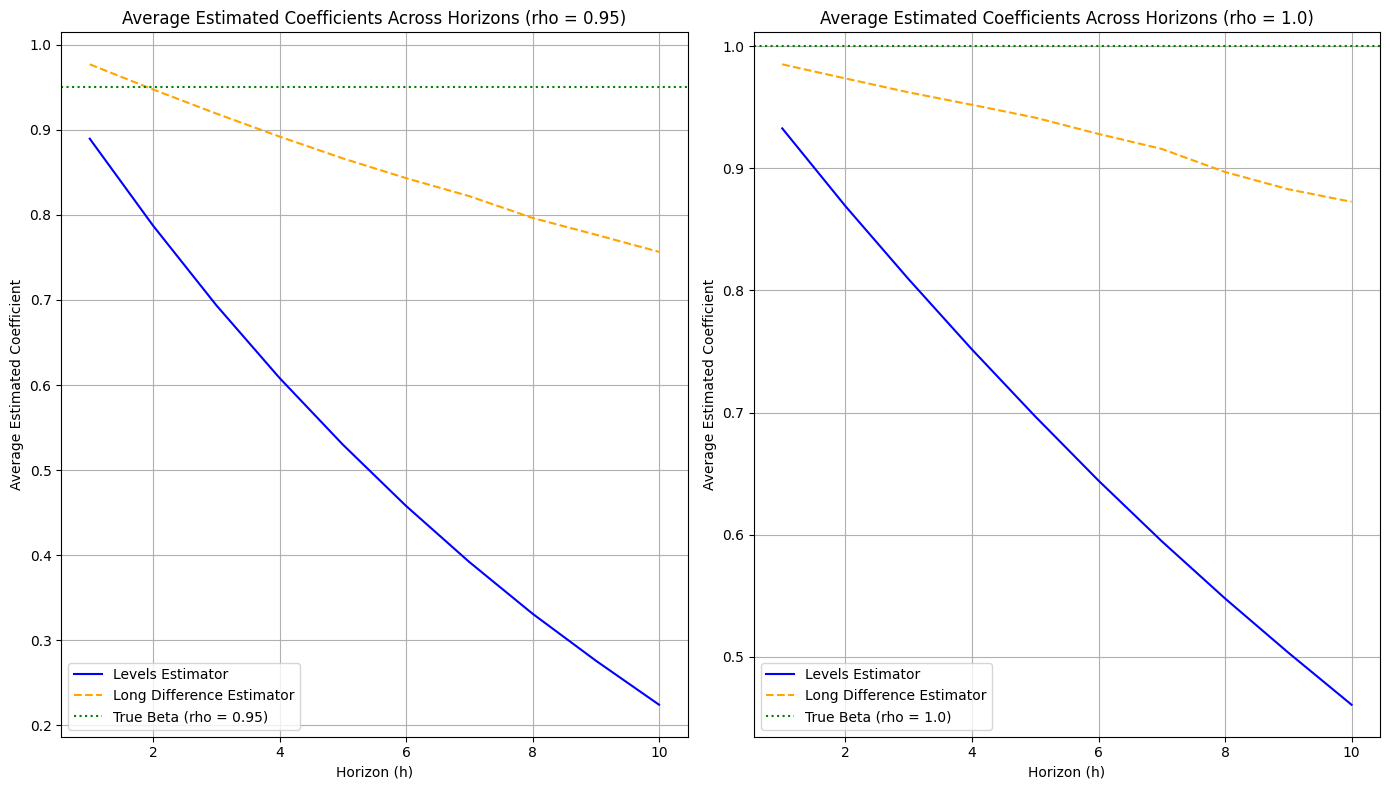

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set parameters
T = 80      # Sample size for each simulation
N_sims = 1000  # Number of Monte Carlo simulations
rho_values = [0.95, 1.0]
horizons = 10

# Fix seed for reproducibility
np.random.seed(42)

# Initialize dictionary to store results
results = {rho: {'levels': np.zeros((N_sims, horizons)),
                 'long_diff': np.zeros((N_sims, horizons))} for rho in rho_values}

# Monte Carlo Simulation
for rho in rho_values:
    for sim in range(N_sims):
        # Generate time series for each simulation
        y = np.zeros(T)
        s = np.random.normal(0, 1, T)
        epsilon = np.random.normal(0, 1, T)
        
        # Generate the series according to the DGP
        for t in range(1, T):
            y[t] = s[t] + rho * y[t-1] + epsilon[t]
        
        # Estimate coefficients for each horizon
        for h in range(1, horizons + 1):
            # Prepare data for the OLS regression at horizon h
            y_t = y[1:T-h]  # Independent variable: y_t
            y_th = y[h+1:T]  # Dependent variable for levels estimator: y_{t+h}
            diff_y_h = y_th - y[:T-h-1]  # Dependent variable for long difference estimator
            diff_y_t = y_t - y[:T-h-1]  # Dependent variable for long difference estimator
            
            # Add constant to y_t for OLS
            y_t_const = sm.add_constant(y_t)
            diff_y_t_const = sm.add_constant(diff_y_t)
            
            # Levels estimator OLS: Regress y_{t+h} on y_t
            model_levels = sm.OLS(y_th, y_t_const).fit()
            results[rho]['levels'][sim, h-1] = model_levels.params[1]  # Store coefficient of y_t
            
            # Long difference estimator OLS: Regress (y_{t+h} - y_t) on y_t
            model_long_diff = sm.OLS(diff_y_h, diff_y_t_const).fit()
            results[rho]['long_diff'][sim, h-1] = model_long_diff.params[1]  # Store coefficient of y_t

# Plotting the average coefficients across simulations for each rho in subplots
plt.figure(figsize=(14, 8))

for i, rho in enumerate(rho_values):
    avg_levels = np.mean(results[rho]['levels'], axis=0)
    avg_long_diff = np.mean(results[rho]['long_diff'], axis=0)
    
    plt.subplot(1, 2, i + 1)
    plt.plot(range(1, horizons + 1), avg_levels, label="Levels Estimator", color="blue")
    plt.plot(range(1, horizons + 1), avg_long_diff, label="Long Difference Estimator", color="orange", linestyle="--")
    
    # Horizontal line for the true beta
    plt.axhline(y=rho, color='green', linestyle=':', label=f'True Beta (rho = {rho})')
    
    plt.xlabel("Horizon (h)")
    plt.ylabel("Average Estimated Coefficient")
    plt.title(f"Average Estimated Coefficients Across Horizons (rho = {rho})")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


**OBSERVATION**
- We have run a simple VAR on each of the cryptocurrencies returns and we have found that the coefficients ranges between 0.95 and 0.99, so we wanted to test the LP estimators bias using a monte carlo simulation that samples from the model 

**OBSERVATION**
- LP gives the same clustering as CAR method
- LP shows higher impact of the attack that CAR method.